In [33]:
library(readxl)
library(plyr)
library(dplyr)
library(ggplot2)
library(repr)
library(ez)
library(reshape2)
library(stringr)
library(gmodels)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 0. Data imports

I'm working directly from Excel format. Variables below specify urls etc.

The 'Questions' tab contains all questions asked to each group of participants; we can map questions by row number to their corresponding columnns for legends etc. This tab also contains a variable name for long questions.

In [2]:
filename <- 'AllResponses.xlsx'

#Load the responses
questions <- read_excel(filename, sheet = "Questions")
acad_questions <- read_excel(filename, sheet = "AcadQuestions")
nonacad_questions <- read_excel(filename, sheet = "NonAcadQuestions")
student_questions <- read_excel(filename, sheet = "StudentQuestions")
fics <- read_excel(filename, sheet = "FICS")

academics_en <- read_excel(filename, sheet = "Academic EN")
academics_mt <- read_excel(filename, sheet = "Academic MT")
nonacademics_en <- read_excel(filename, sheet = "NonAcademic EN")
nonacademics_mt <- read_excel(filename, sheet = "NonAcademic MT")
students_en <- read_excel(filename, sheet = "Student EN")
students_mt <- read_excel(filename, sheet = "Student MT")

# 00. Functions
This is just code I reuse again and again.

The function below:
* maps all FICS names to acronyms (to avoid excessive length)
* collapses some gender variables which are rare
* renders some variables as factors
* deletes all cases where respondents did not explicitly give consent

In [3]:
factorise <- function(df, factors) {
    
     for (f in factors) {
        df[,f] <- factor(df[,f])
    }
    
    return(df)
}

map_vars <- function(df, factors = c('Age', 'Gender', 'FICS')) {
       
     df[df$Lang=='MT',]$FICS <- mapvalues(df[df$Lang=='MT',]$FICS, 
          from=fics$MT, 
          to=fics$ACRONYM, warn_missing=FALSE)

    df[df$Lang=='EN',]$FICS <- mapvalues(df[df$Lang=='EN',]$FICS, 
          from=fics$EN, 
          to=fics$ACRONYM, warn_missing=FALSE)
    
    #There are some rare gender values, which can be collapsed
    df$Gender <- mapvalues(df$Gender, 
                           from=c("non-binary/genderfluid", "Non-classifiable", "nonbinary"), 
                           to=c("nonbinary", "nonbinary", "nonbinary"), warn_missing=FALSE)    

   df <- factorise(df, factors)
    
    df <- subset(df, Consent == 'I give my consent')
    return(df)
}



The function below takes a DF, one or more group variables, and a measure variable and returns a summary (mean, SD and standard err of the mean).

In [4]:
# New version of length which can handle NA's: if na.rm==T, don't count them
length2 <- function (x, na.rm=TRUE) {
    if (na.rm) sum(!is.na(x))
    else       length(x)
}

## Summarizes data.
## Gives count, mean, standard deviation, standard error of the mean
##Modified after the source here: https://www.rdocumentation.org/packages/plyr/versions/1.8.6/topics/ddply
summary <- function(data=NULL, measurevar, groupvars=NULL, na.rm=TRUE,
                      conf.interval=.95, .drop=TRUE) {    

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          Mean = mean   (xx[[col]], na.rm=na.rm),
          SD   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    datac$SE <- datac$SD / sqrt(datac$N)  # Calculate standard error of the mean

      # Rename the "mean" column    
#     datac <- rename(datac, c("Mean" = paste("Mean", measurevar, sep="_"),
#                             "SD" = paste("SD", measurevar, sep="_"),
#                             "N" = paste("N", measurevar, sep="_"),
#                             "SE" = paste("SE", measurevar, sep="_")))

    return(datac)
}

The function below "melts" a dataset into long format, and recodes specific variables to facilitate analysis.

In [5]:
melt_data <- function(df, vars, contextvar, idvars=NA) {
    df_sub <- data.frame(df[vars])
    
    if (is.na(idvars)) {
        mlt <- melt(df_sub)
    } else {
        mlt <- melt(df_sub, id.vars=idvars)
    }
    
    mlt$Lang <- ifelse( grepl('MTEN', mlt$variable), 'MTEN', 
                                 ifelse( grepl('EN', mlt$variable), 'EN', 'MT'))
    mlt$Context <- str_match(mlt$variable, contextvar)
    mlt$Lang <- as.factor(mlt$Lang)
    mlt$Context <- as.factor(mlt$Context)
    return(mlt)
} 

Below we set some global options for graphs

In [49]:
#Set global options for plots
options(repr.plot.width=14, repr.plot.height=10)

# 1. Data prep

Data is preprocessed as follows:


Additional variables introduced to indicate group (student/academic/non-academic) and langauge of response

In [7]:
academics_en <- data.frame(Role='Academic', QLang='EN', academics_en)
academics_mt <- data.frame(Role='Academic', QLang='MT', academics_mt)

nonacademics_en <- data.frame(Role='Nonacademic', QLang='EN', nonacademics_en)
nonacademics_mt <- data.frame(Role='Nonacademic', QLang='MT', nonacademics_mt)

students_en <- data.frame(Role='Student', QLang='EN', students_en)
students_mt <- data.frame(Role='Student', QLang='MT', students_mt)

Rename the first 157 variables (which are common to all DFs), ie those up to section 6.7 inclusive. Note that these include the new Role and Lang Variables.

In [8]:
#All variable names of common DFs
var_names <- c(c('Role', 'Lang'), questions$VariableName[1:155])

names(nonacademics_en) <- c(var_names, nonacad_questions$VariableName)
names(nonacademics_mt) <- c(var_names, nonacad_questions$VariableName)

names(students_en)  <- c(var_names, student_questions$VariableName)
names(students_mt)  <- c(var_names, student_questions$VariableName)

names(academics_en) <- c(var_names, acad_questions$VariableName)
names(academics_mt) <- c(var_names, acad_questions$VariableName)

We'll also separate out the specific questions for each Role into DFs

In [9]:
academics <- rbind(academics_en, academics_mt)[c('Consent', 'Lang', 'Age', 
                                                 'Residence', 'Gender', 'FICS', acad_questions$VariableName)]

nonacademics <- rbind(nonacademics_en, nonacademics_mt)[c('Consent', 'Lang', 'Age', 
                                                 'Residence', 'Gender', 'FICS', nonacad_questions$VariableName)]

students <- rbind(students_en, students_mt)[c('Consent', 'Lang', 'Age', 
                                                 'Residence', 'Gender', 'FICS', student_questions$VariableName)]

Add an "ID" variable, which is just a dummy for subject ID (useful later as the error/variance term in ANOVAs etc)

In [10]:
#Each row is a participant: Id is just an integer, but represented as factor
academics$ID <- factor(paste('A', rep(1:nrow(academics)), sep=""))
nonacademics$ID <- factor(paste('NA', rep(1:nrow(nonacademics)), sep=""))
students$ID <- factor(paste('S', rep(1:nrow(students)), sep=""))

#IDs are just numbers, represented as factors
# common <- cbind(ID, common)

Merge all questions up to Section 6.7 (inclusive) into one DF, as these are common to all. Note that this corresponds to columns 3 to 157 for all DFs (after insertion of role and lang info)

In [11]:
#Common is a new DF, containing all responses from all categories, up to Section 6.7 inclusive
common <- rbind(academics_en[,1:157], 
                academics_mt[,1:157], 
                nonacademics_en[,1:157], 
                nonacademics_mt[,1:157], 
                students_en[,1:157], 
                students_mt[,1:157])

common$ID <- factor(rep(1:nrow(common)))

For all datasets, Section 5 responses in MT have an inverted scale (1=agree) compared to EN (1=disagree). The MT ones are transformed to conform to the EN scale. This is done by subtracting the result from 6 (so 5 becomes 1, etc).

In [12]:
sec5_vars <- c("ComfortMT", "ComfortEN", "ComfortAR", "ComfortIT", "ComfortFR", "ComfortDE", "ComfortES", "ComfortOTHER", "CultureMT", "CultureEN", "CultureAR", "CultureIT", "CultureFR", "CultureDE", "CultureES", "CultureMULTILING", "CultureOTHER", "ProficiencyAimMT", "ProficiencyAimEN", "ProficiencyAimAR", "ProficiencyAimIT", "ProficiencyAimFR", "ProficiencyAimDE", "ProficiencyAimES", "ProficiencyAimOTHER")

for (v in sec5_vars) {
    common[common$Lang=='MT',][,v] <- 6 - common[common$Lang=='MT',][,v]
}

In [13]:
# academics <- map_vars(academics)
common <- map_vars(common)
academics <- map_vars(academics)
nonacademics <- map_vars(nonacademics)
students <- map_vars(students)

In [14]:
#And make some other vars factors for each sub-df
academics <- factorise(academics, acad_questions$VariableName)
nonacademics <- factorise(nonacademics, nonacad_questions$VariableName)
students <- factorise(students, student_questions$VariableName)

# 2 Analysis

## 2.1 General overview

### Age, gender and language preference for the questionnaire

In [28]:
gender.age.lang.role <- ddply(common, .(Role, Age, Gender, Lang), summarize, 
                         N=length2(Role))

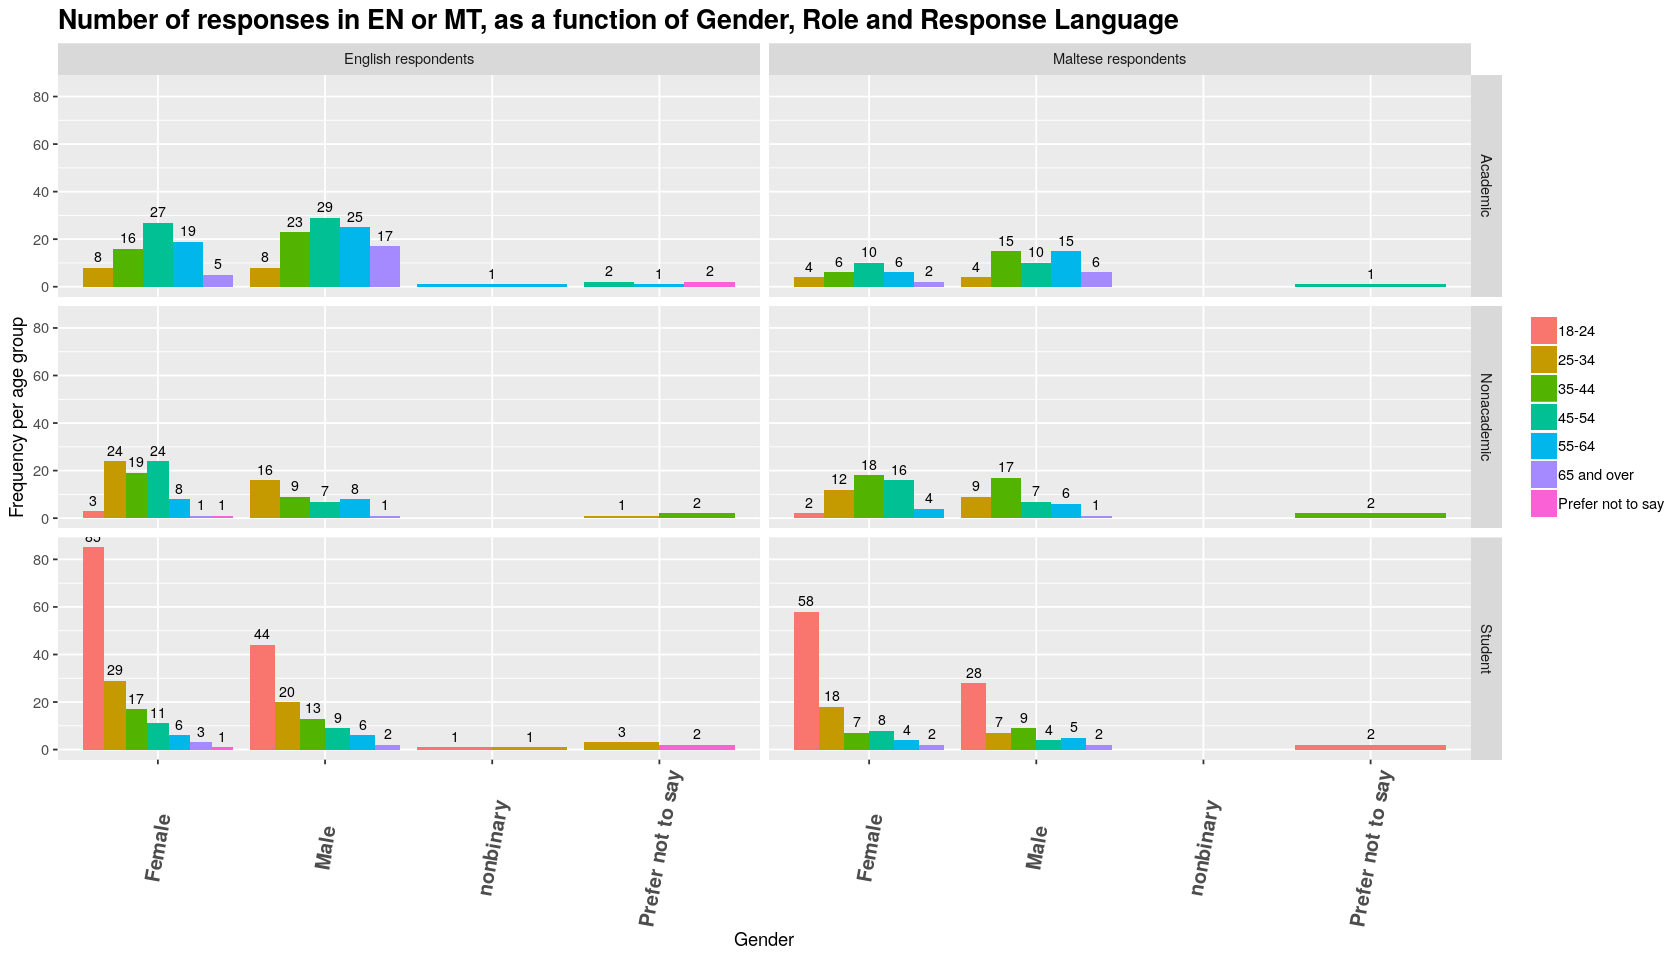

In [31]:
ggplot(gender.age.lang.role, aes(x=Gender, y=N, fill=Age)) +
    geom_bar(position="dodge", stat="identity") +   
    geom_text(aes(label=N), size=3, position=position_dodge(width=0.9), vjust=-0.5) +
    ggtitle("Number of responses in EN or MT, as a function of Gender, Role and Response Language") +
    theme(axis.text.x = element_text(angle=80, vjust=.5, size=12, face='bold')) +
    labs(y="Frequency per age group", x="Gender") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) + 
     facet_grid(rows=vars(Role), cols=vars(Lang),
        labeller=labeller(Lang = c(EN="English respondents", MT="Maltese respondents")))


### Who answered from which faculty, and in what language? (Academics and students)

In [36]:
fics.role.lang <- ddply(subset(common, Role != "Nonacademic"), .(FICS, Role, Lang), 
                        summarize, NFic=length(FICS), NLang=length(Lang))

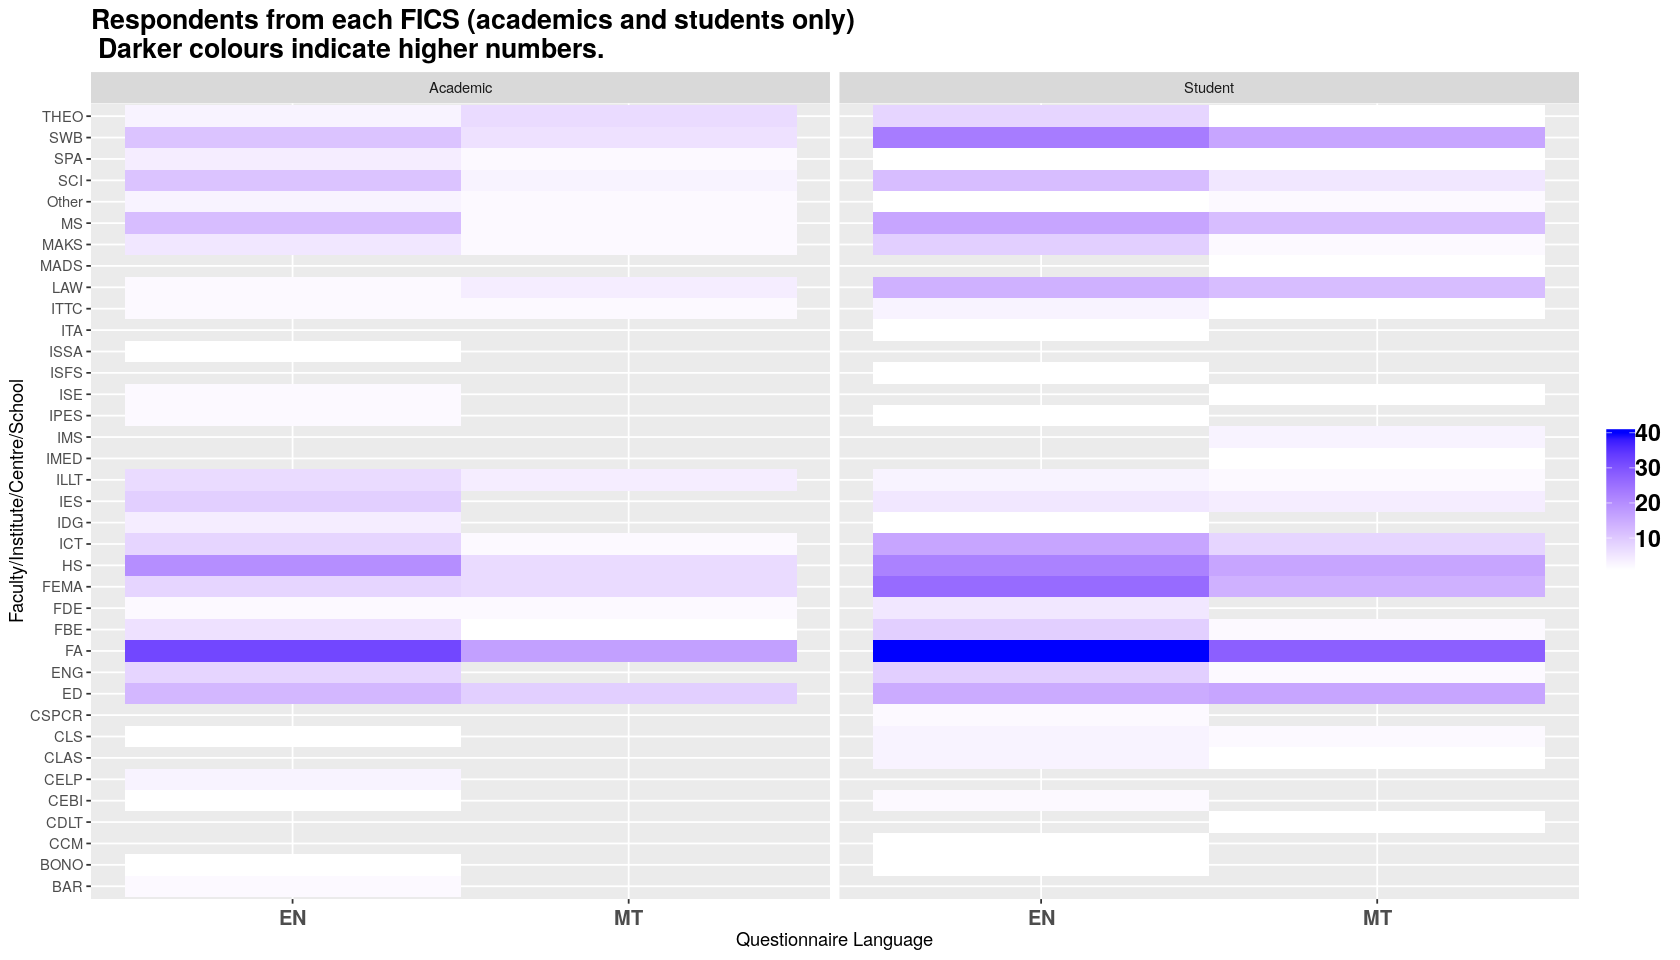

In [37]:
ggplot(fics.role.lang, aes(fill=NFic, x=Lang, y=FICS)) +
    geom_tile() + 
    scale_fill_gradient(low="white", high="blue") + 
    ggtitle("Respondents from each FICS (academics and students only) \n Darker colours indicate higher numbers.") + 
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) +
    labs(y="Faculty/Institute/Centre/School", x="Questionnaire Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=14, face="bold")) + 
    facet_grid(. ~ Role)


### Among academics/students, how did language questionnaire preference distribute by FICS?

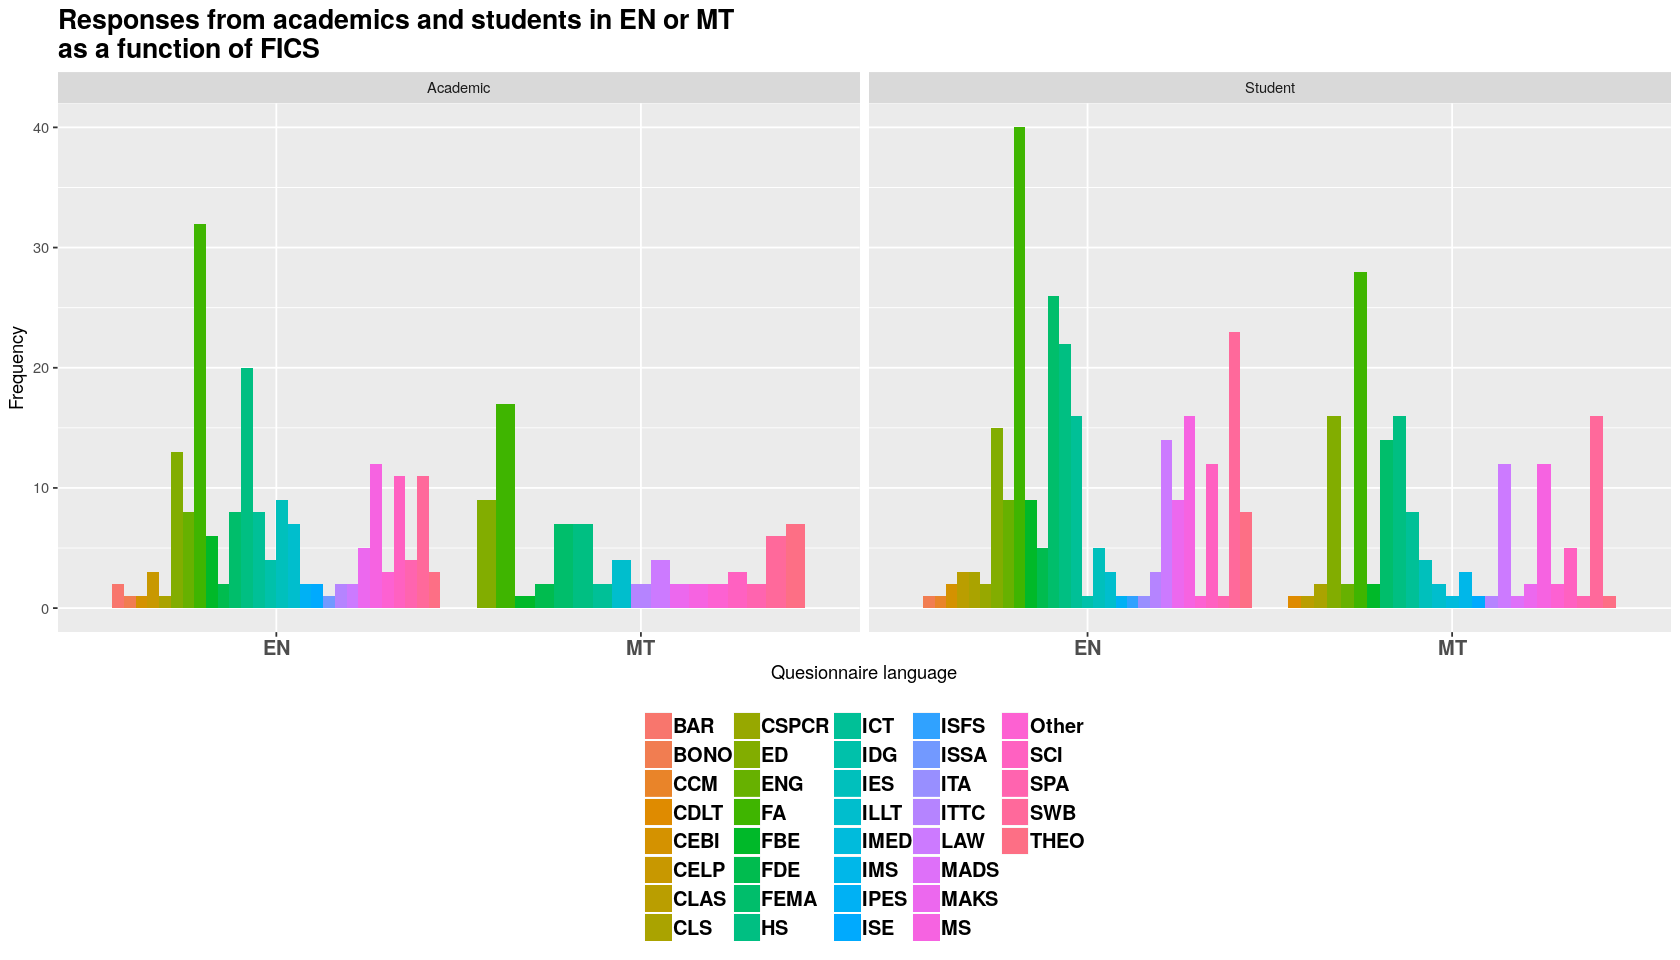

In [39]:
ggplot(fics.role.lang, aes(fill=FICS, x=Lang, y=NLang)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(. ~ Role) +
    theme(legend.position="bottom") +
    ggtitle("Responses from academics and students in EN or MT\nas a function of FICS") +
    ylab("Frequency") +
    xlab("Quesionnaire language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(size=12, face='bold'))


## 2.2 Language Use

The following focusses on the questions in Section 3 of the questionnaires. For the time being, we only focus on EN and MT.

It's handier to reshape the data into long format, such that we have separate variables for Language and UseContext (family, friends, etc). 

In [40]:
lang_mlt <- melt_data(common, c("ID", "Role", "Residence", "Gender", "FICS",
                                  "UseFriendsEN", "UseFriendsMT", "UseFamilyEN", "UseFamilyMT",
                                  "UseUniEN", "UseUniMT", "UsePrivateEN", "UsePrivateMT"), 
                                 "Family|Uni|Friends|Private") 


Using ID, Role, Residence, Gender, FICS as id variables



In [41]:
# Summarise the data for Section 3
# We want to split by role (AC, NAC and ST) and compute mean, SD, and standard err, as well as N
lang.use <- summary(lang_mlt, "value", groupvars=c("Role", "Context", "Lang"));

### In an average week, what percentage of the time do participants use EN and MT in different contexts?

The plot below shows mean self-reported time, as a function of role (non-/academic or student). Observe that all self-reports suggest a higher proportion of time spent using MT than EN, *with the exception of University for students and academics, but not non-academics.* 

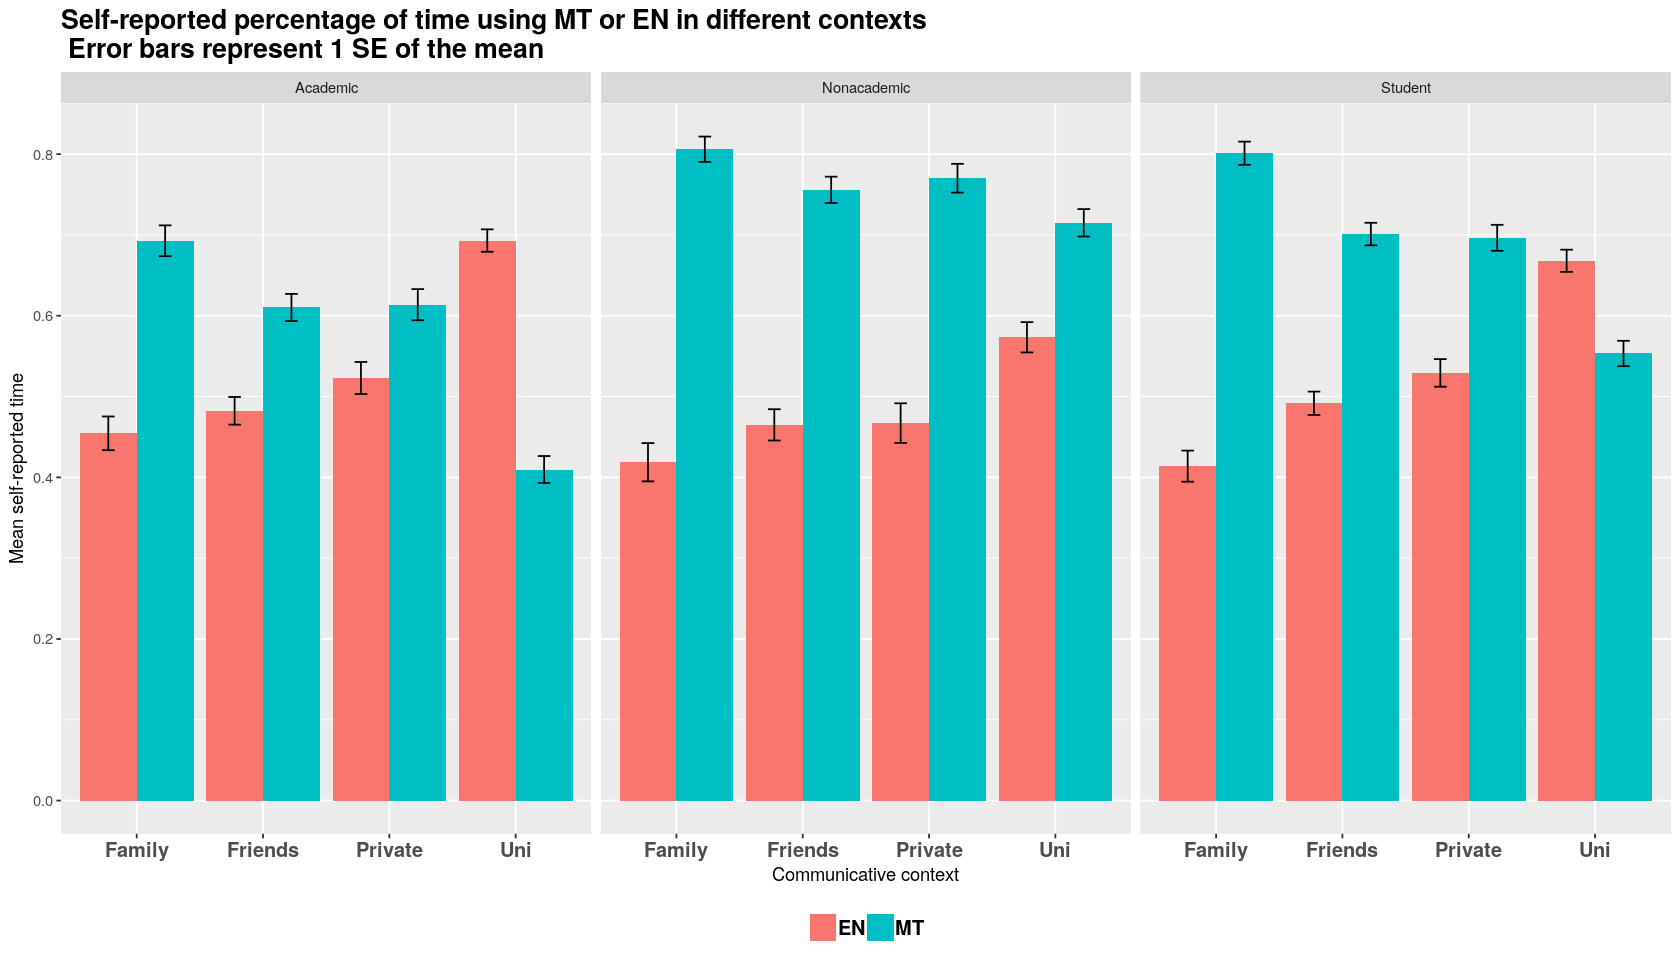

In [42]:
ggplot(lang.use, aes(fill=Lang, x=Context, y=Mean)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(. ~ Role) +
    theme(legend.position="bottom") +
    ggtitle("Self-reported percentage of time using MT or EN in different contexts \n Error bars represent 1 SE of the mean") +
    ylab("Mean self-reported time") +
    xlab("Communicative context") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(size=12, face='bold')) +
    geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))

* Across the board, there is a predominance of Maltese as the language of communication among Family and Friends, and in private.
* Students and Academics report that they predominantly communicate in English when at University; this is not the case for non-academics.

### Does Context (family, friends, uni, private) exercise a significant effect in self-reported language use, and does this interact with participant Role as academic/student or non-academic?

Below are the results of an ANOVA taking Value (= self-reported proportion of time spent using a language) as dependent variable, and looking at the impact of Role, Language and Context.

Note that we only use complete cases for this (i.e. cases where we don't have any missing values for any of the self-reports)

**NB** In the analysis below, we are making the simplifying assumption that these are "real" proportions. In fact, participants were given values to select (and no zero value). However, since the scale was clearly a percentage scale, it seems safe to assume that it was interpreted numerically by respondents. On the other hand, we do not assume that no response implies 0% (participants might have chosen not to respond for other reasons).

In [43]:
#Check how many observations we had before and after
lang.mlt.complete <- lang_mlt[complete.cases(lang_mlt),]
nrow(lang.mlt.complete)

[1] 6038

In [44]:
lang.use.aov <- anova(lm(value~(Role*Lang*Context), data=lang.mlt.complete)); lang.use.aov

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Role,2,3.9328427,1.96642137,25.5229546,9.168511e-12
Lang,1,33.6999957,33.69999567,437.4054679,8.120063e-94
Context,3,0.5873822,0.19579405,2.5412878,5.456208e-02
Role:Lang,2,10.9063492,5.45317459,70.7788929,4.142909e-31
Role:Context,6,0.1997934,0.03329890,0.4321995,8.578603e-01
Lang:Context,3,38.7763201,12.92544002,167.7643581,1.907674e-104
Role:Lang:Context,6,3.1512675,0.52521124,6.8169228,3.204349e-07
Residuals,6014,463.3498867,0.07704521,NA,NA


The ANOVA suggests that the (self-reported) proportion of time people spend using a language is strongly dependent on:

1. Whether the language is MT or EN (i.e. there is a significant difference in self-reported use of EN vs MT)
2. The effect of language used is moderated by both Role (as shown in the graph, Academics and Students differ from non-academics in their self-reported use) and by Context (whether one is speaking to friends, at uni etc)
    

## 2.3 Language proficiency

In this section, we look at self-reported results on language proficiency in Maltese, English. 

First, some preprocessing as before

In [45]:
profic_mlt <- melt_data(common, c("ID", "Role", "Residence",
                                "Gender", "FICS",
                                "SpeakEN", "SpeakMT",
                                "UnderstandEN", "UnderstandMT",
                                "ReadEN", "ReadMT",
                                "WriteEN", "WriteMT"), 
                               "Speak|Read|Write|Understand")

Using ID, Role, Residence, Gender, FICS as id variables



Since the values here are from an ordinal scale, we'll create a version of the Value variable whcih is a factor. We only keep non-missing cases.

In [46]:
profic_mlt$Value.F <- as.factor(profic_mlt$value)

This time, it's easier to summarise using a frequency table (can compute proportions).

In [47]:
totals <- prop.table( ftable( table( profic_mlt$Role, profic_mlt$Lang, 
                                    profic_mlt$Context, profic_mlt$Value.F), 
                             margins=2), 1) * 100
proficiency <- data.frame(totals)
names(proficiency) <- c("Role", "Lang", "Skill", "Value", "Prop")

### What is respondents' self-reported proficiency in English or Maltese?

Below we show the frequency with which they ranked themselves on each scale element (from 1 to 5), as a function of their Role and the Language spoken. Panels are by Role and Language.

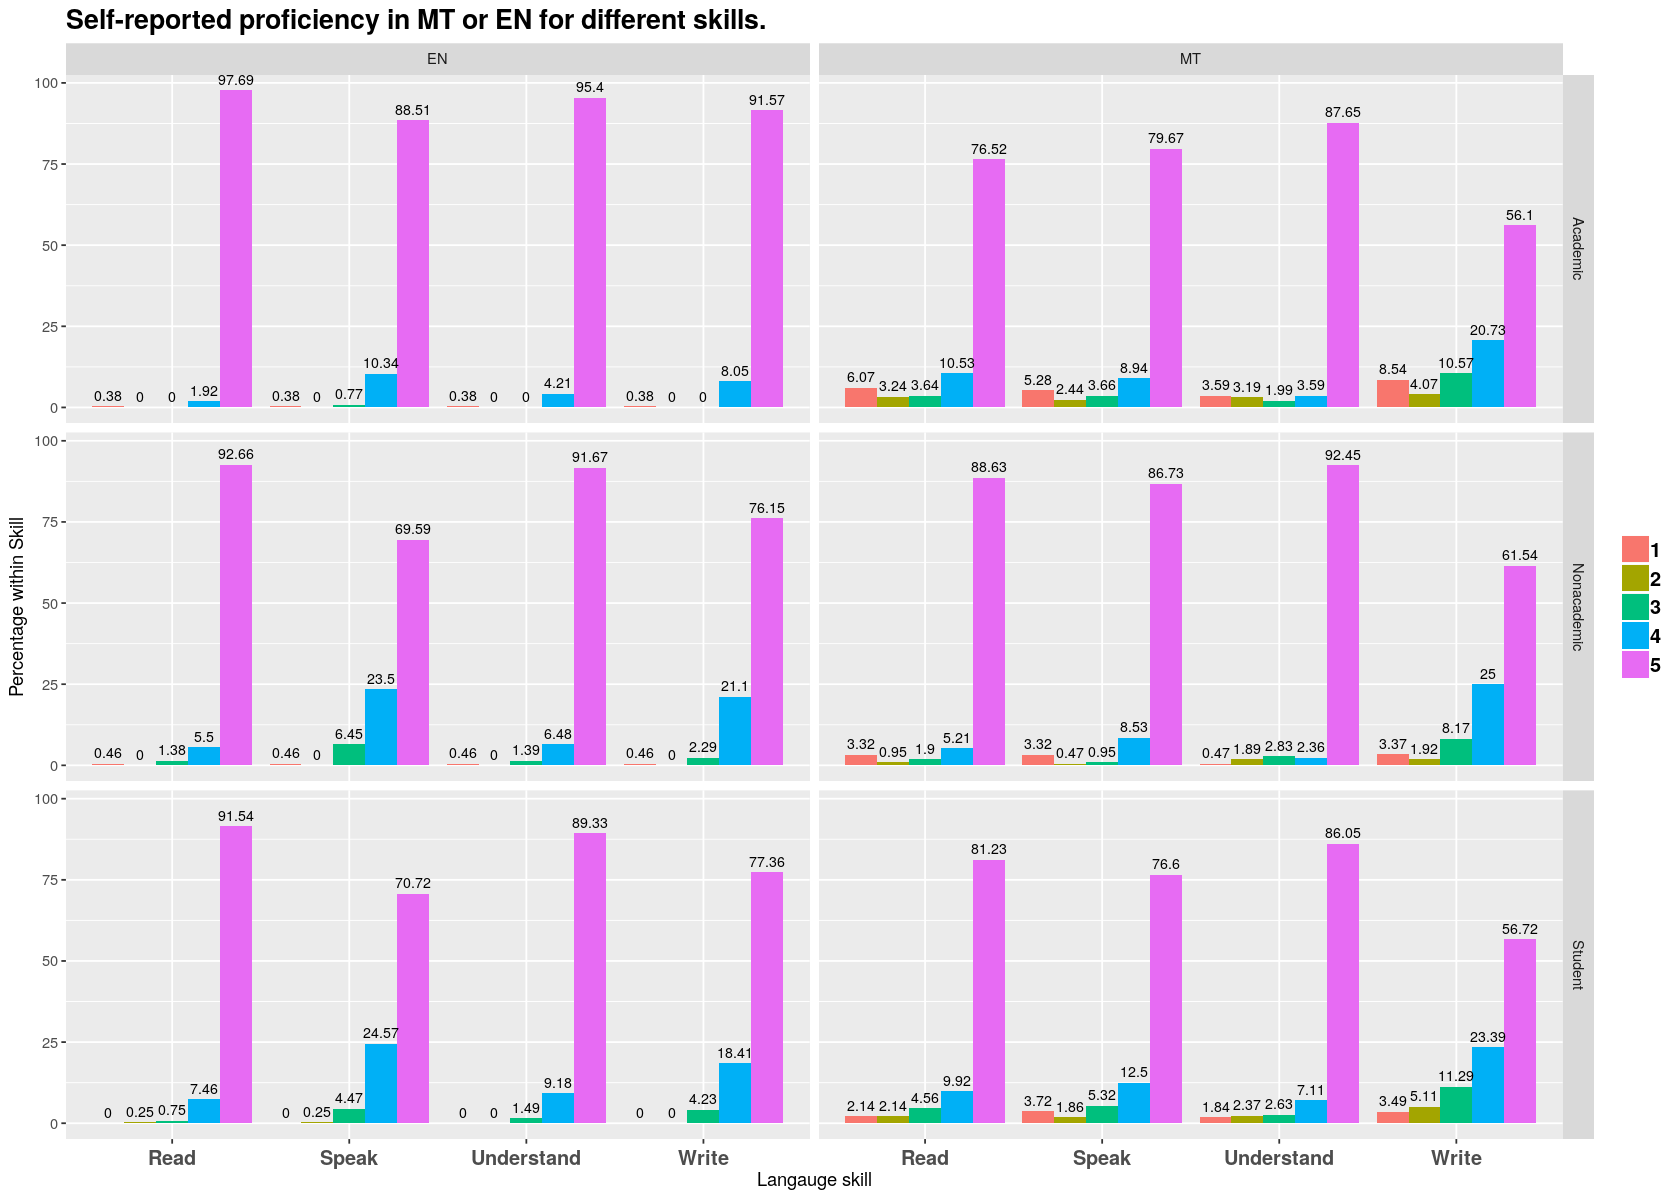

In [52]:
ggplot(proficiency, aes(fill=Value, x=Skill, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(cols=vars(Lang), rows=vars(Role)) +
#     theme(legend.position="bottom") +
    ggtitle("Self-reported proficiency in MT or EN for different skills.") +
     geom_text(aes(label=round(Prop,2)), size=3, position=position_dodge(width=0.9), vjust=-0.5) +
    labs(y="Percentage within Skill", x="Langauge skill") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

### Does self-reported proficiency differ depending on Role and Skill?

We'll run an ANOVA as before, this time looking at self-reported proficiency as a function of Role in the two languages. We'll do this for each Skill separately.

**NB** Strictly speaking, likert-type scales like this one aren't parametric, but studies have shown parametric tests can be used reasonably safely.

In [53]:
#As usual, only consider non-NA cases
profic_mlt.complete <- profic_mlt[complete.cases(profic_mlt),]

skills <- c("Read", "Speak", "Understand", "Write")

#Store ANOVA results in a DF
results <- data.frame("Skill" = character(), 
                      "Role"=double(), 
                      "Lang"=double(), 
                      "Role:Lang"=double(), 
                      stringsAsFactors=FALSE)


get_f <- function(an, r) {
    f_score = toString(round(an[r,]$F, 2))
    f = ""
    
    if (an[r,]$P < 0.05) paste(f_score, "*", sep="")
    else f_score    
}

for (s in skills) {
    an <- anova(lm(value~(Role*Lang), data=profic_mlt.complete[profic_mlt.complete$Context==s,]))
    results[nrow(results)+1,] <- c(s, get_f(an,1), get_f(an,2), get_f(an,3))
}

results

,Skill,Role,Lang,Role.Lang
,<chr>,<chr>,<chr>,<chr>
1,Read,1.92,74.19*,6.8*
2,Speak,3.12*,7.17*,8.96*
3,Understand,1.33,26.46*,3.2*
4,Write,0.73,168.49*,8.59*


As the above shows, for all four skills, the self-reported proficiency differs significantly. A main effect of role is only observed for Speaking. Role interacts significantly with Language.

## 2.4 Self-appraisal when using different languages

In this section, we consider the questions related to how participants feel when they use Maltese or English, and how they identify culturally.

### Which language are respondents most comfortable using?

First, we consider responses to the question "I feel like myself when I speak..." in relation to Maltese and English. The table and chart below show the proportion of responses for each item on the ordinal scale from 1 to 5, for this question in relation to MT and EN.

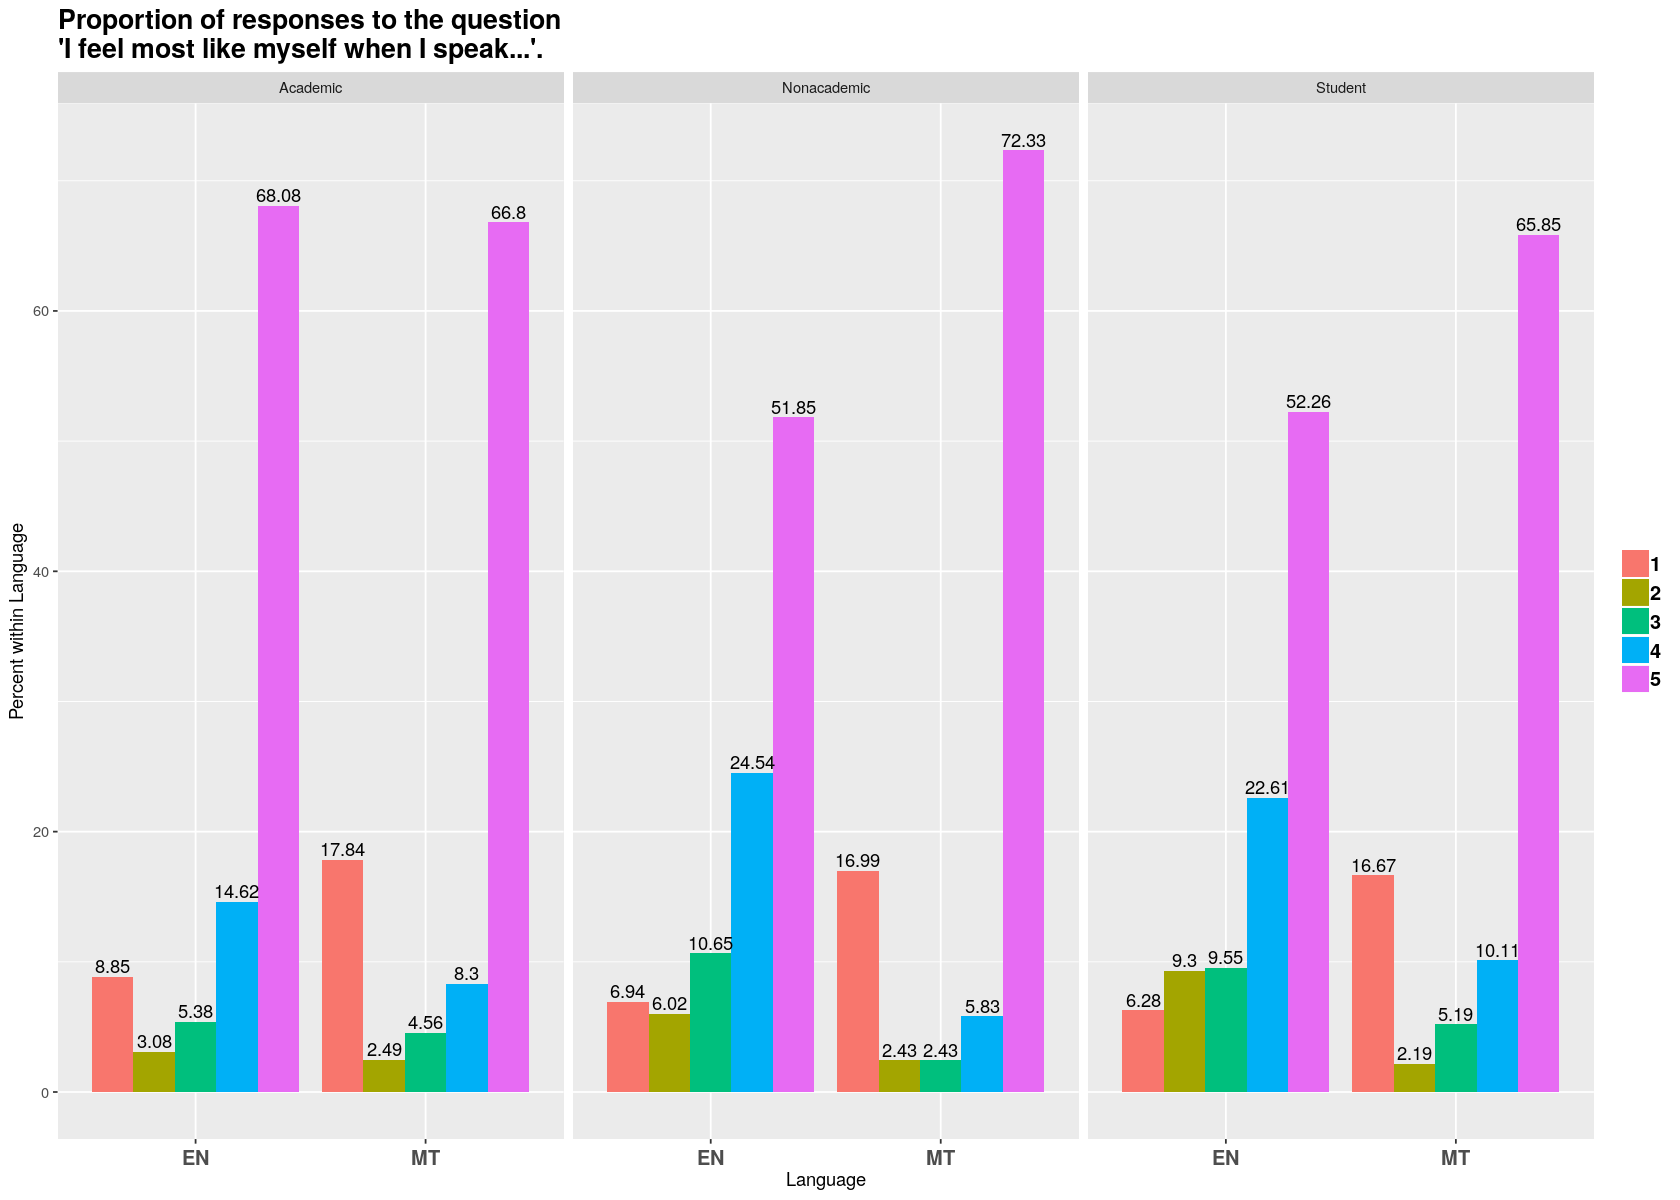

In [54]:
comf.mt <- data.frame(prop.table(table(common$Role, common$ComfortMT), 1) * 100)
comf.mt$Lang <- "MT"
comf.en <- data.frame(prop.table(table(common$Role, common$ComfortEN), 1) * 100)
comf.en$Lang <- "EN"

comf <- rbind(comf.mt, comf.en);
names(comf) <- c("Role", "Response", "Prop", "Lang")

ggplot(comf, aes(fill=Response, x=Lang, y=Prop, label=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25) +
    facet_grid(. ~ Role) +
    ggtitle("Proportion of responses to the question\n'I feel most like myself when I speak...'.") +
    labs(y= "Percent within Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

Main observations:
* Among academics, there is a roughly equal proportion of 5-responses
* Among non-academics and students, the proportions suggest greater ease when speaking Maltese. This difference is more pronounced for non-academics.

### Which linguistic culture do respondents identify with?

Next, we consider responses to the question "I identify with a culture that is..." in relation to Maltese and English. The table and chart below show the proportion of responses for each item on the ordinal scale from 1 to 5, for this question in relation to MT and EN.

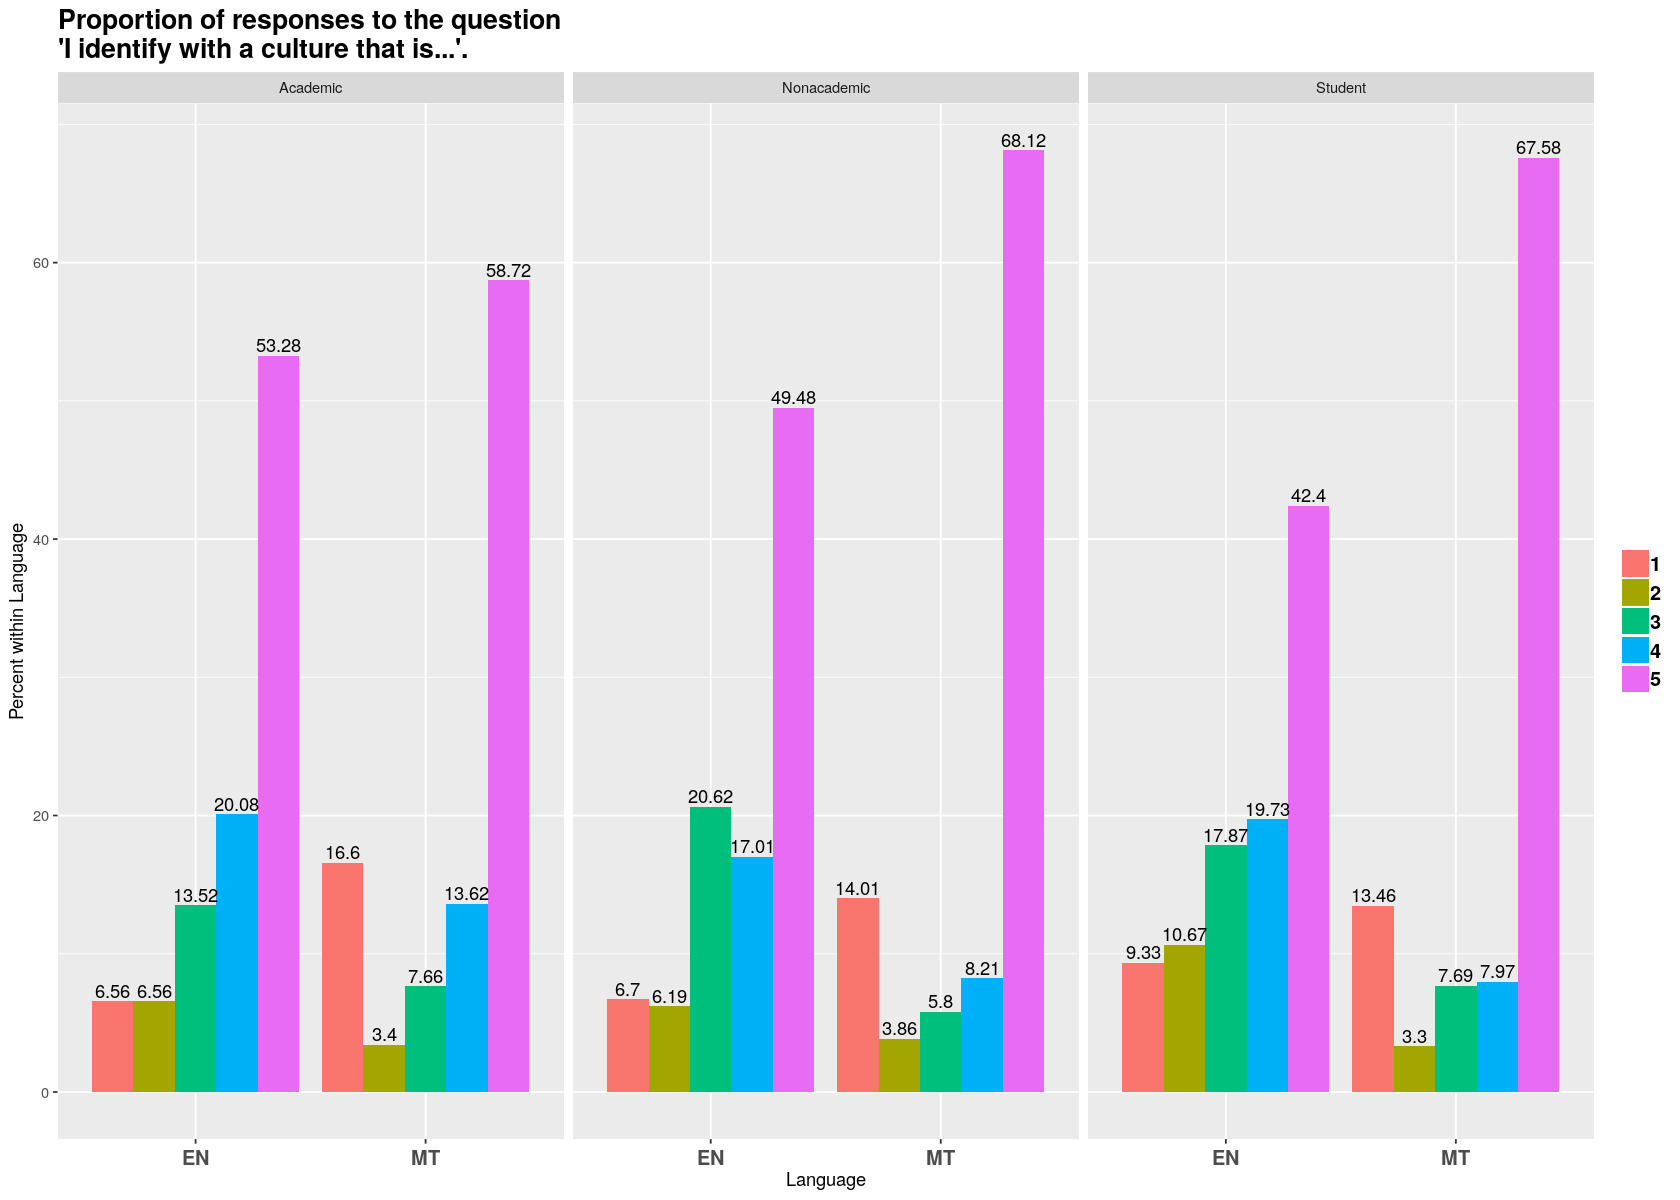

In [55]:
cult.mt <- data.frame(prop.table(table(common$Role, common$CultureMT), 1) * 100)
cult.mt$Lang <- "MT"
cult.en <- data.frame(prop.table(table(common$Role, common$CultureEN), 1) * 100)
cult.en$Lang <- "EN"

cult <- rbind(cult.mt, cult.en);
names(cult) <- c("Role", "Response", "Prop", "Lang")

ggplot(cult, aes(fill=Response, x=Lang, y=Prop, label=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25) +
    facet_grid(. ~ Role) +
    ggtitle("Proportion of responses to the question\n'I identify with a culture that is...'.") +
    labs(y="Percent within Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

This time, the trend in favour of maximal identification with a Maltese-speaking culture is also evident among academics; however, the difference between EN and MT is once again more pronounced for non-academics and students.

An intersting question is whether the question of cultural identification and the extent to which one is comfortable speaking a language are correlated (this is what one would expect). Below is the outcome of a Spearman correlation by ranks between these two questions, for English and Maltese separately.

In [56]:
cor.test(common$CultureMT,common$ComfortMT, method="spearman")
cor.test(common$CultureEN,common$ComfortEN, method="spearman")

Warning message in cor.test.default(common$CultureMT, common$ComfortMT, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  common$CultureMT and common$ComfortMT
S = 20005000, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7546913 


Warning message in cor.test.default(common$CultureEN, common$ComfortEN, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  common$CultureEN and common$ComfortEN
S = 34738000, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6078022 


In both cases, the correlation is of medium to high strength and significantly different from 0. The correlation is stronger for MT than for EN.

### How important a goal is proficiency in these languages?

Next, we consider responses to the question *It is important to me to use (or eventually use) the language below at a high level of proficiency*.

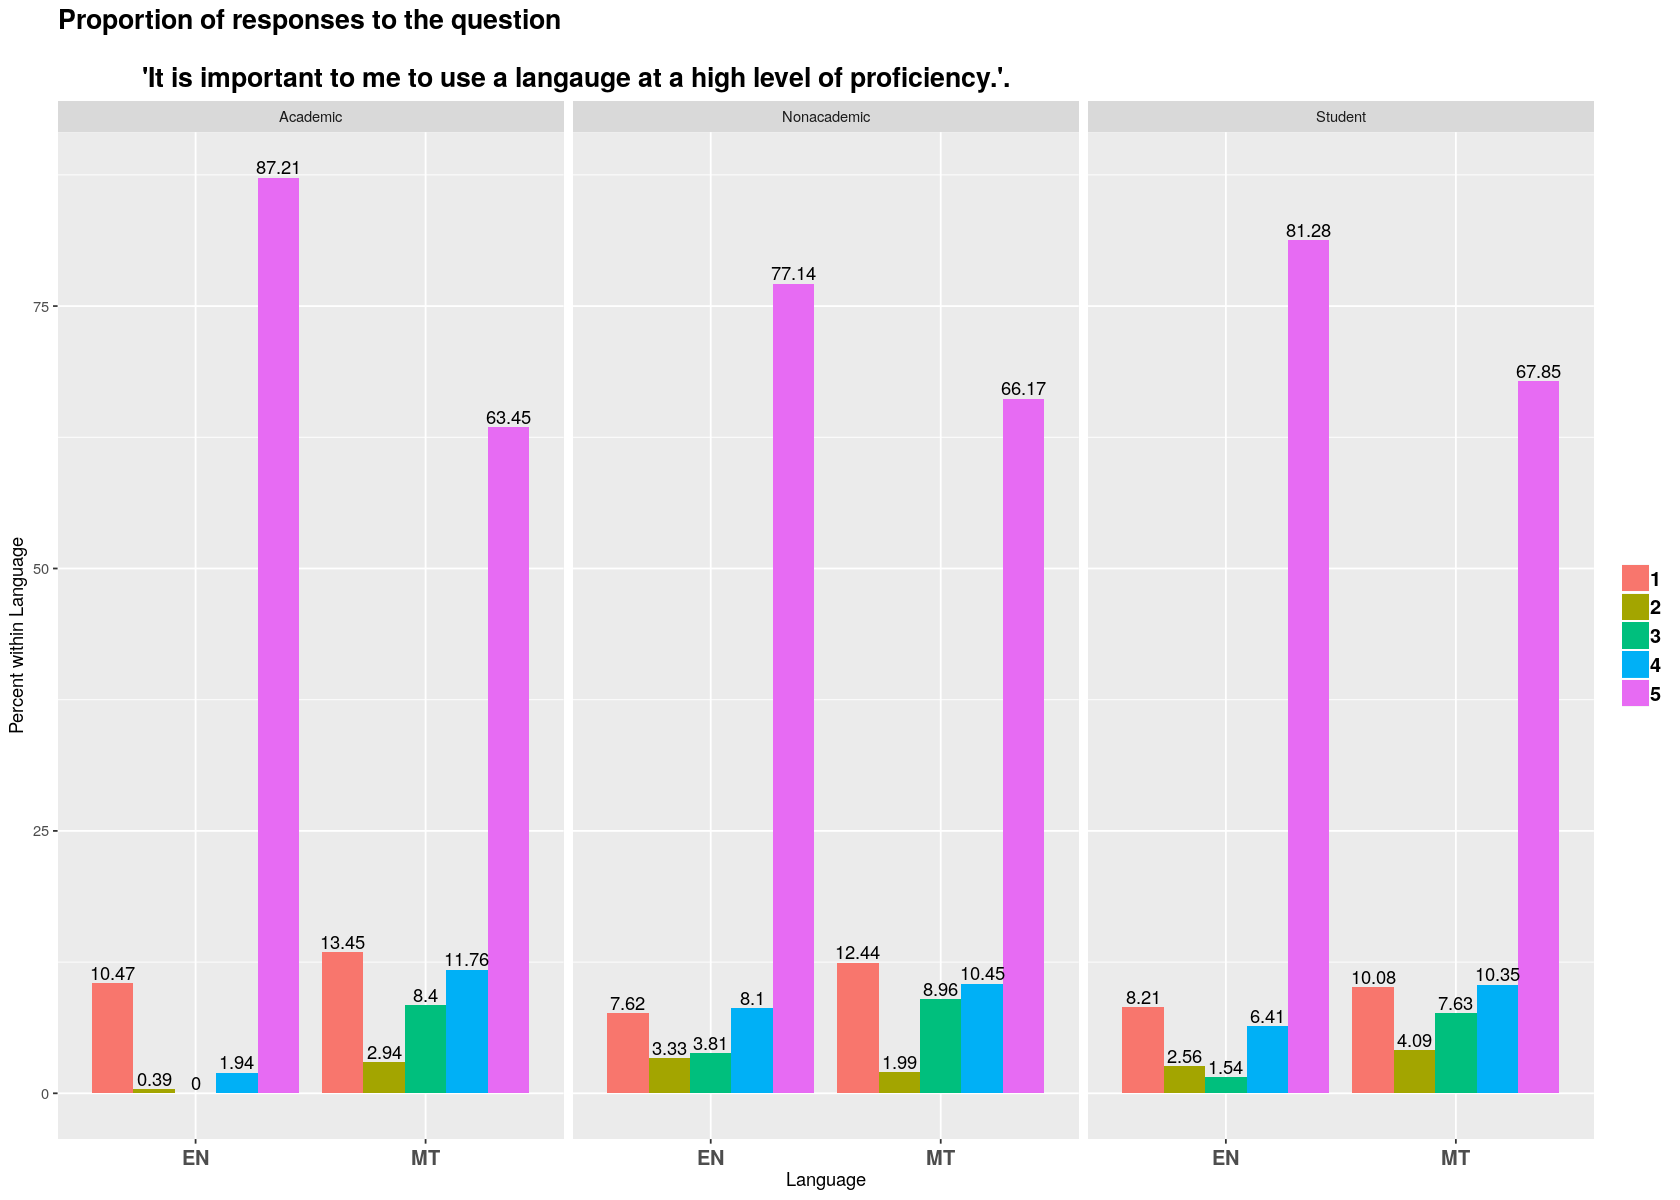

In [57]:
aim.mt <- data.frame(prop.table(table(common$Role, common$ProficiencyAimMT), 1)*100)
aim.mt$Lang <- "MT"
aim.en <- data.frame(prop.table(table(common$Role, common$ProficiencyAimEN), 1)*100)
aim.en$Lang <- "EN"

aim <- rbind(aim.mt, aim.en);
names(aim) <- c("Role", "Response", "Prop", "Lang")

ggplot(aim, aes(fill=Response, x=Lang, y=Prop, label=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25) +
    facet_grid(. ~ Role) +
    ggtitle("Proportion of responses to the question\n
            'It is important to me to use a langauge at a high level of proficiency.'.") +
    labs(y="Percent within Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

In this case, we observe a shift in the trends observed above. For most of these participants (but particularly for academics and students), a high proficiency in EN is perceived as crucial, and more so than in MT. At the same time, academics and students do acknowledge that being proficient in Mt is important to them.

# 3. Language on campus

## 3.1 Questions common to all respondents

We first look at the questions in Section 6 of the questionnaire that were asked to all respondents, irrespective of role.

Once again, we first change some variables into factors.

### How do respondents view the UM? (Bilingual, monolingual..) and should it change?

It makes sense to view these responses together.

In [ ]:
desc <- data.frame(round(prop.table(table(common$DescribeUni)),2))
names(desc) <- c("DescribeUni", "PropDU")
change <- data.frame(round(prop.table(table(common$DescribeUniChange)), 2))
names(change) <- c("Change", "PropChange")

desc; change

Taken individually, these responses suggest that most respondents view the university as bilingual, and don't see  a reason to change this. 

It is instructive to see these responses together, enabling us to ask whether people who do not view the uni as bilingual view it as necessary to change this. We also include University role as an additional variable.

In [ ]:
descChange <- data.frame( round( prop.table( ftable( table(common$Role, 
                                                          common$DescribeUni, 
                                                          common$DescribeUniChange), margins=2), 
                                            1) * 100,  
                                2)  
                        )
names(descChange) <- c("Role", "ViewUni", "Change", "Prop")

In [ ]:
ggplot(descChange, aes(x=ViewUni, fill=Change, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25)  +
    facet_grid(. ~ Role) +
    ggtitle("Views on the University language situation") +
    labs(y="Percentage", x="University Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

Clearly, individuals who see University as monolingual Maltese are strongly in favour of changing this. This is consistent with the earlier result showing that while individuals mostly view themselves as Maltese-speaking, they view proficiency in English as a desirable goal.

Further observations:
* Academics evince a stronger tendency to view the university as bilingual or multilingual
* While all (100%) academics and non-academics who view the university as monolingual Maltese consider it desirable to change this, not all students in this category do, although they are still the majority (83%).



How this should be changed, and the reasons for their answers, requires an analysis of the content of their free-text responses to the question asking them to give reasons (question 6.1c).

### Signage and websites 

We now turn to views regarding public communications, in the form of signage and websites.

In [ ]:
comms_mlt <- melt_data(common, c("ID", "Role", "FICS", "WebsiteMT", 
                                 "WebsiteEN", "WebsiteMT+EN", "SignageMT", 
                                 "SignageEN", "SignageMT+EN"),
                       "Signage|Website",
                       idvars= c("ID", "Role", "FICS")
                      )

In [ ]:
#And now summarise the data
props <- prop.table(ftable(table(comms_mlt$Role, comms_mlt$Context, 
                                 comms_mlt$Lang, comms_mlt$value), margin=2), 1) * 100
commdata <- data.frame(round(props,2))
names(commdata) <- c("Role", "Domain", "Lang", "Value", "Prop")

In [ ]:
ggplot(commdata, aes(x=Lang, fill=Value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=Prop), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_grid(rows=vars(Domain), cols=vars(Role)) +
    ggtitle("Views on University website and campus signage") +
    labs(y="Percent within Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

For signage:
* Irrespective of role, most respondents do not agree that signage should be exclusively in MT
* Among academics, there are roughly equal proportions who agree and disagree that signage should be exclusively in EN. The majority of students and non-academics disagree.
* Across all roles, most respondents agree that signage should be bilingual (MT and EN)

For the website:
* Irrespective of role, most respondents do not agree that the UM website should be exclusively in MT.
* Among non-academics and academics, there is some agreement that the website could be in EN only.
* Across all roles, most respondents express a preference for a bilingual website. The proportions who said 'agree' to this option are greater than those who agreed with the proposition that the website should be exclusively in EN.

### Tuition and training in different languages

Respondents were asked whether they would be interested in courses in MT for specific purposes, and courses to enhance proficiency in EN, Mt and other languages.

In [ ]:
courses_mlt <- melt_data(common, c("ID", "Role", "FICS", 
                                   "CoursesSpecificPurposesMT", 
                                   "ExtraLangCourseMT", 
                                   "ExtraLangCourseEN"),
                         "Specific|Extra",
                         idvars=c("ID", "Role", "FICS")
                        )
courses_mlt$Type <- factor(courses_mlt$Context, labels=c("Extra curricular", "MT for Specific Purposes"))

In [ ]:
props <- prop.table(ftable(table(courses_mlt$Role, courses_mlt$Type, 
                                 courses_mlt$Lang, courses_mlt$value), 
                           margin=2), 1) * 100
data <- data.frame(round(props,2))
names(data) <- c("Role", "Type", "Lang", "Value", "Prop")

 ggplot(subset(data, Type=="Extra curricular"), aes(x=Lang, fill=Value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=Prop), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_grid(cols=vars(Role)) +
    ggtitle("Willingness to take extra curricular courses") +
    labs(y="Percent within Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 


The only cohorts who express interest in extra-curricular MT or EN courses are non-academics (for MT) and students (again, for MT). 

In [ ]:
ggplot(subset(data, !is.na(Value) & Type=="MT for Specific Purposes"), aes(x=Role, fill=Value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=Prop), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
#     facet_grid(cols=vars(Role)) +
    ggtitle("Interest in MT for specific purposes") +
    labs(y="Percent within Role", x="Role") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

In contrast, all cohorts evince a high degree of interest in Maltese for specific purposes.

# 4. Questions specific to academics
In this section we turn to a set of questions asked only to academic members of staff.

In [58]:
acad_mlt <- melt_data(academics, c("ID", "FICS", acad_questions$VariableName),
                      "DeliverLectures|ComfLecture|Exams|Papers|SpeakClass|SpeakColleagues|SpeakOutsideClass|StaffMeetings|WriteMessages",
                      idvars=c("ID", "FICS")
                     )

Warning message in if (is.na(idvars)) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“attributes are not identical across measure variables; they will be dropped”


## What languages do academics use in classroom settings? 

Lecturers were asked how often they use EN, Mt or a mixture of both in classroom settings. 

In [91]:
class <- subset(acad_mlt, Context=="DeliverLectures" | Context =="SpeakClass" | 
                Context == "SpeakOutsideClass" )
class$Context <- as.character(class$Context)

#Turn value into a factor and order levels properly
class$value <- factor(class$value, levels=c("always", "most of the time", "some of the time", "never"))

In [92]:
lectures <- data.frame(prop.table(ftable(table(class$Context, class$Lang, class$value), margins=2), 1) * 100)
names(lectures) <- c("Context", "Lang", "value", "Prop")

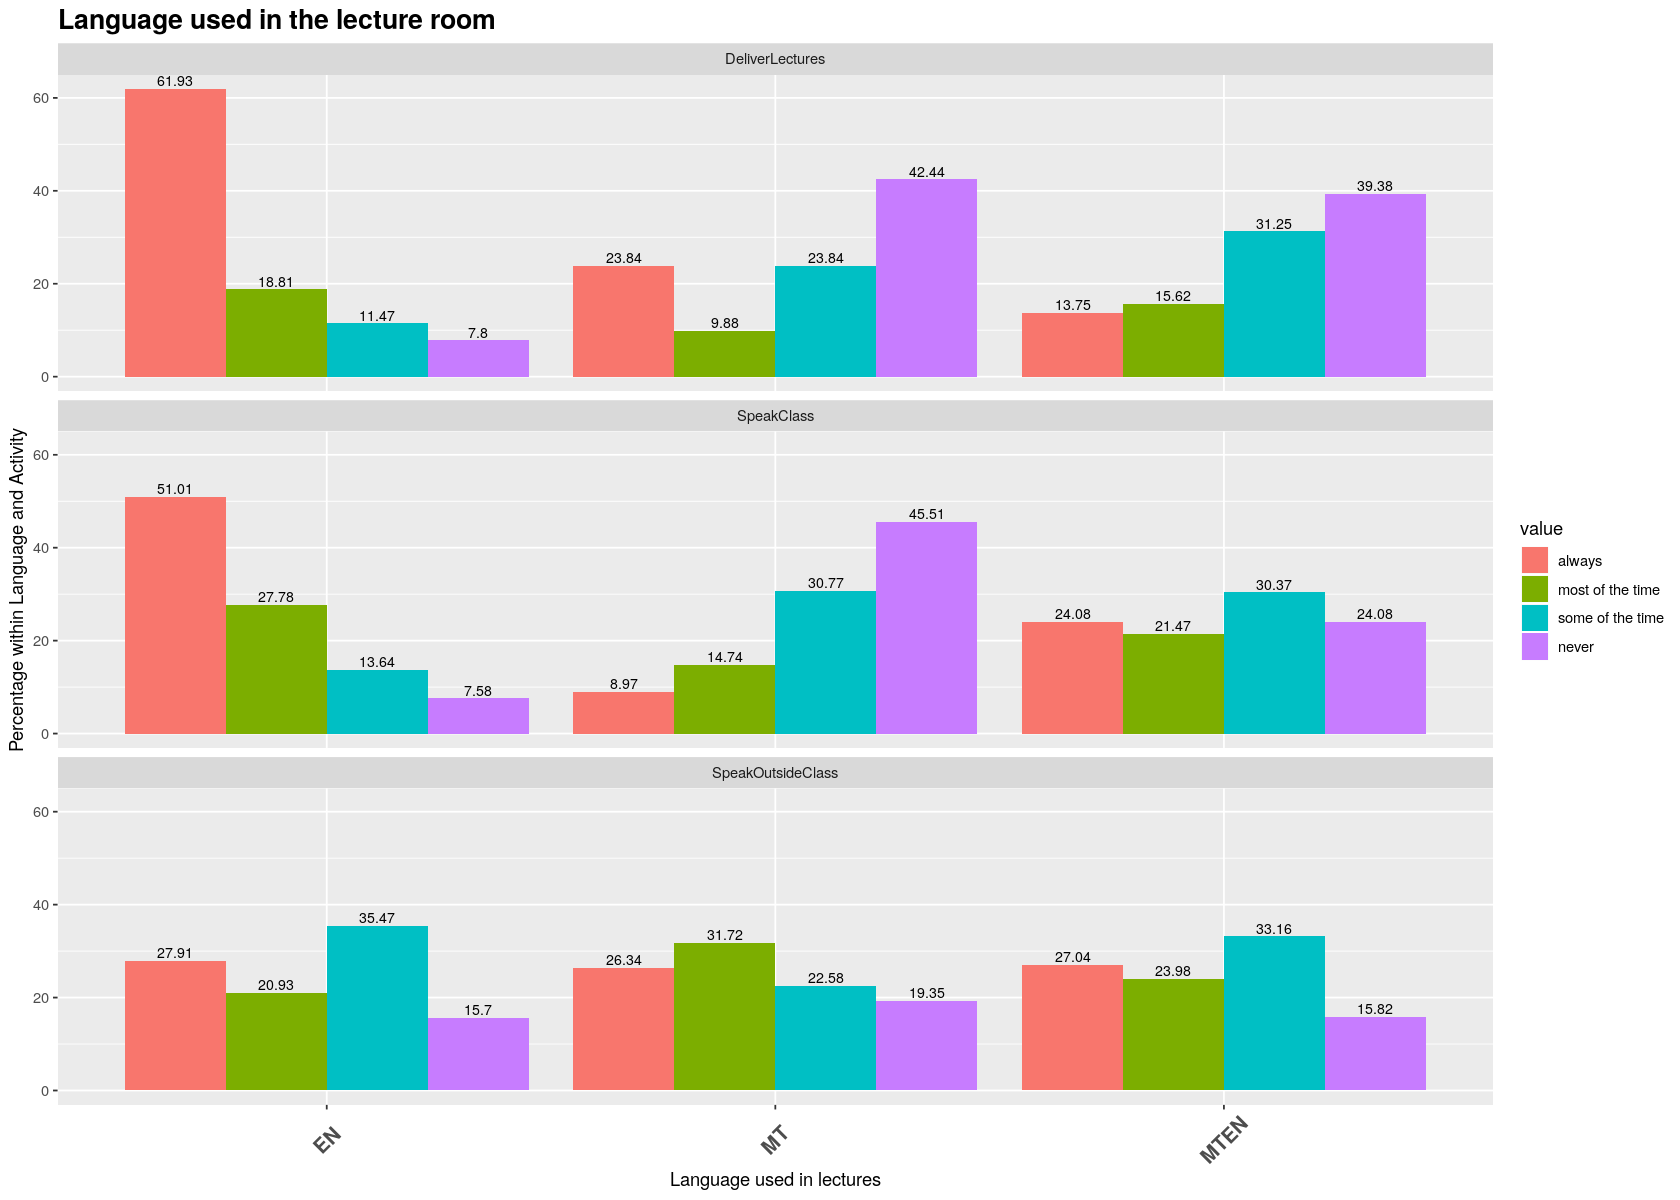

In [93]:
ggplot(subset(lectures, !is.na(value)), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_wrap(~Context, nrow=3) +
    ggtitle("Language used in the lecture room") +
    labs(y="Percentage within Language and Activity", x="Language used in lectures") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 


Main observations:
* Most lecturers report that they only use English in their lectures, with a minority (n=41) that uses Maltese always, and a smaller group that uses a mixture of Maltese and English. We investigate the distribution of these individuals by their affiliation below.
* Similar trends can be observed for self-reported speech habits in class: most lecturers report always speaking in English, though a greater number (46) state that they mix MT and EN, compared to those who claim they always lecture in a mixture of MT and EN.
* Outside of the classroom, there is a greater tendency to mix languages at least some of the time. More academics state they use MT always, and fewer state they use EN always.

We  further inspect the subset that states they use MT always, focussing on the FICS these lecturers belong to.

In [94]:
mt_only <- subset(acad_mlt, Context=="DeliverLectures" & Lang=="MT" & value=="always")

mt_lec <- ddply(mt_only, .(FICS), summarize, N=length2(FICS))

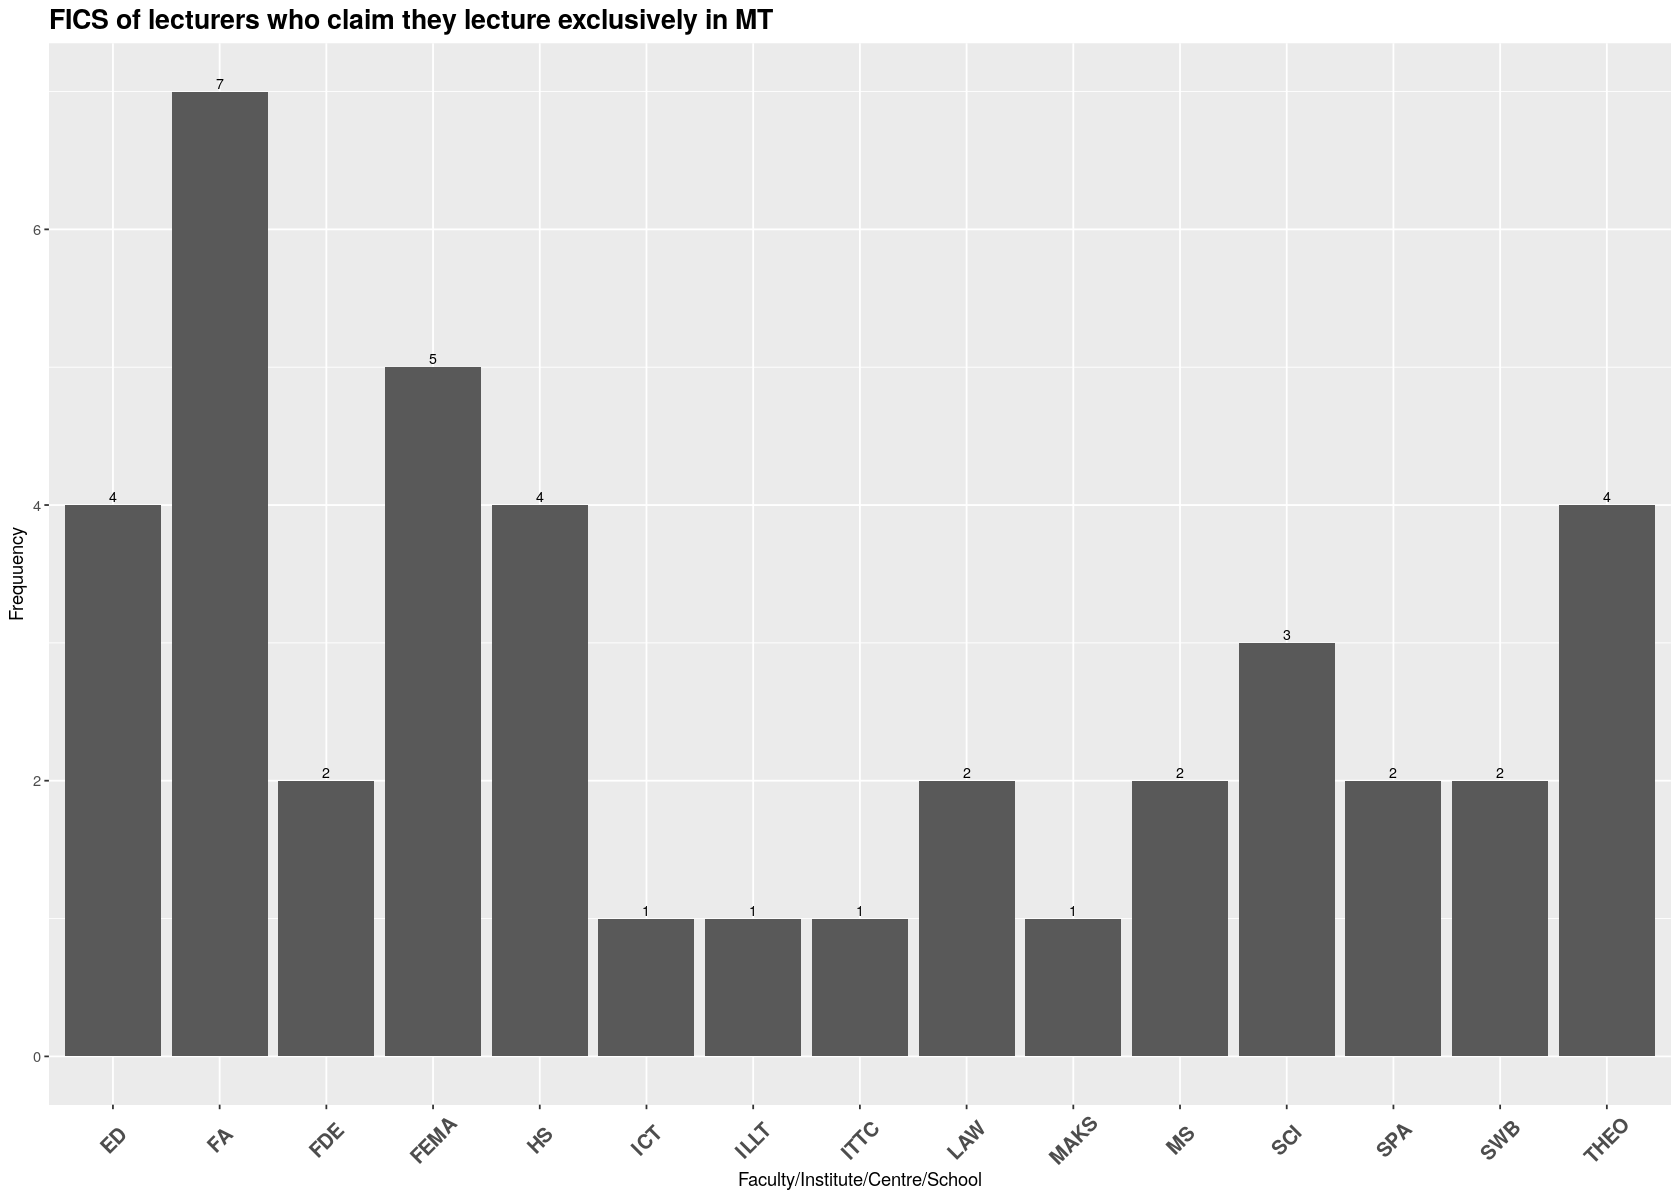

In [95]:
ggplot(mt_lec, aes(x=FICS, y=N)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=N), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
#     facet_grid(cols=vars(Role)) +
    ggtitle("FICS of lecturers who claim they lecture exclusively in MT") +
    ylab("Frequuency") +
    xlab("Faculty/Institute/Centre/School") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

It turns out that the majority is from the Faculty of Arts (FA; presumably, the majority of these belong in the Department of Maltese), closely followed by some lecturers in Education, FEMA and Theology.

## What languages do academics prefer in communication?

Here, we consider the questions asked to academics about their preferred language(s) when writing papers, speaking in staff meetings and writing messages to fellow staff members.

In [114]:
acadcomms <- subset(acad_mlt, Context =="Papers" | Context == "StaffMeetings" | Context=="WriteMessages")
acadcomms$Context <- as.character(acadcomms$Context)

#Turn value into a factor and order levels properly
acadcomms$value <- factor(acadcomms$value, levels=c("disagree", "mildly disagree", "neutral", 
                                                    "mildly agree", "agree"))

In [128]:
comms <- data.frame(prop.table(ftable(table(acadcomms$Context, acadcomms$Lang, acadcomms$value), margins=2), 1) * 100)
names(comms) <- c("Context", "Lang", "value", "Prop")

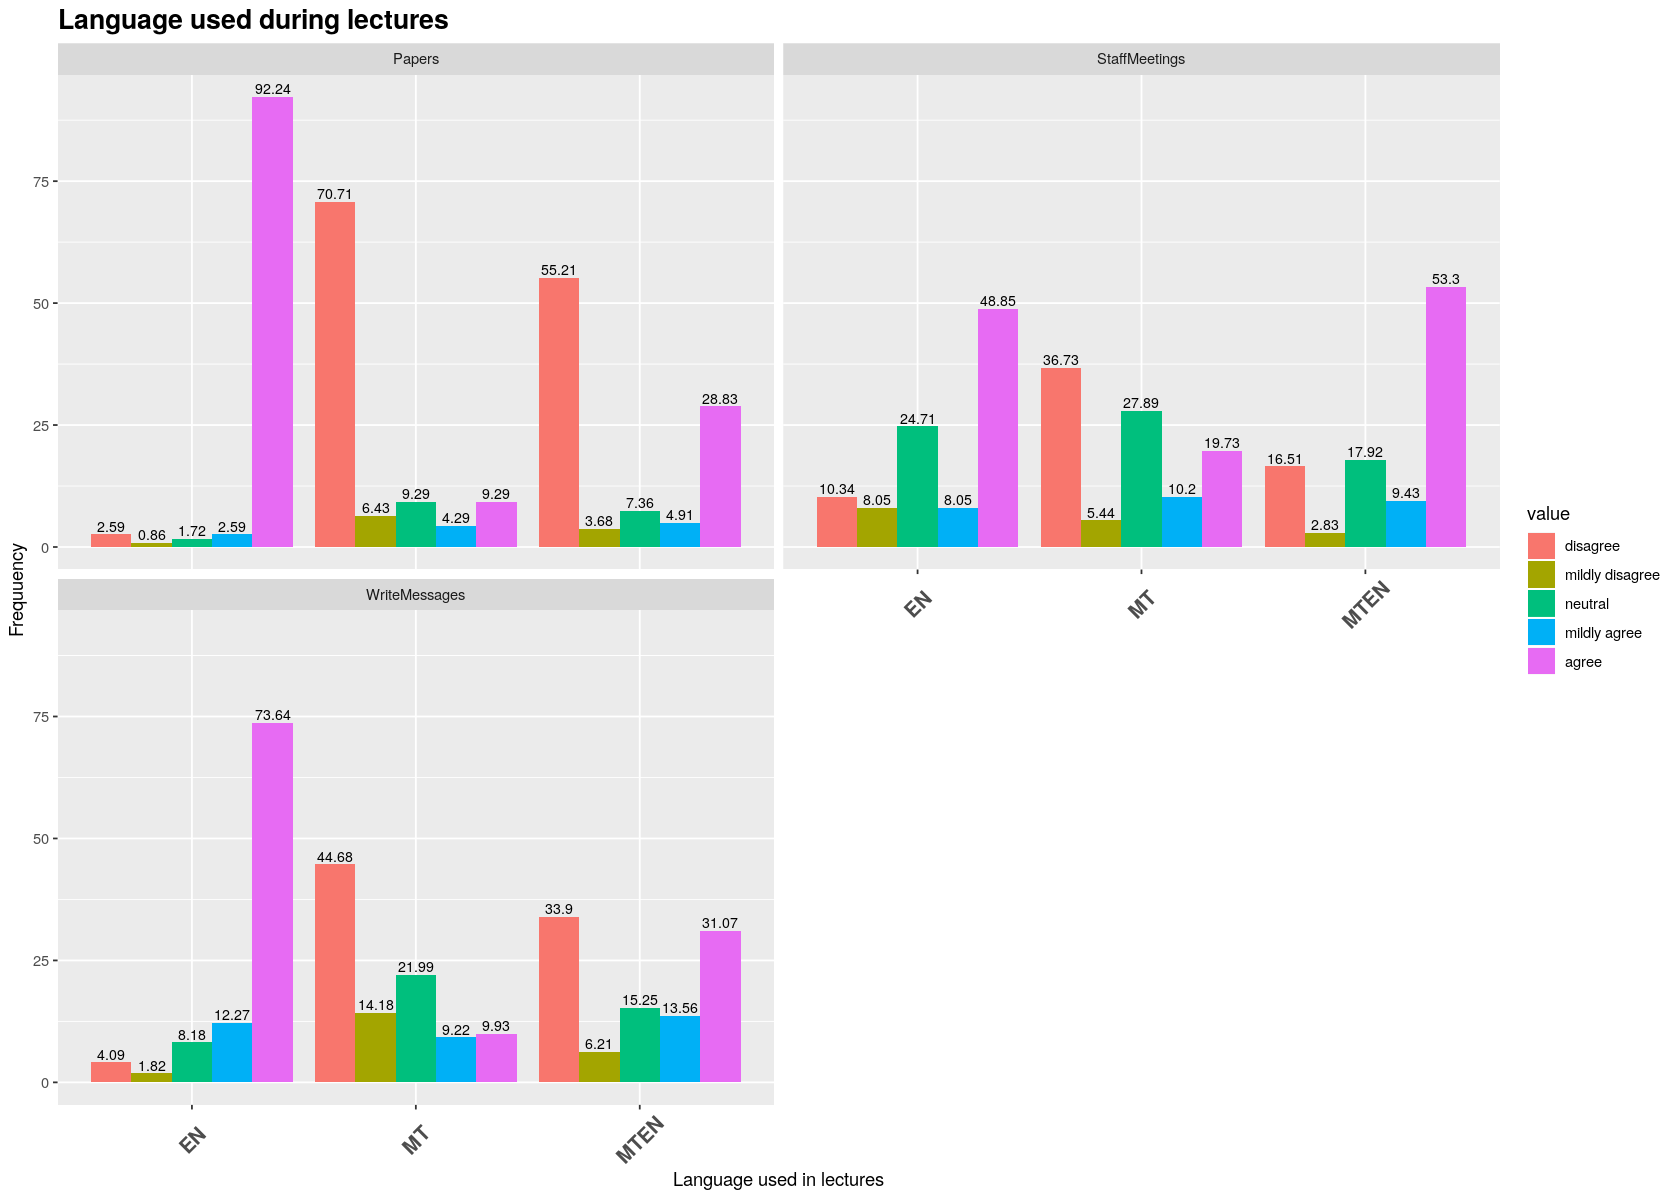

In [117]:
ggplot(subset(comms, !is.na(value)), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_wrap(~ Context, ncol=2) +
    ggtitle("Language used during lectures") +
    labs(y="Frequuency", x="Language used in lectures") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold'))

Not surprisingly, most academics prefer English for writing (both for academic papers and for messages). For staff meetings, there is a tendency to prefer a mixture of EN and MT. Significantly, very few academics evince a strong preference for Maltese-only staff meetings.

# 5. Questions specific to students
Here, we consider questions asked only to students.

In [118]:
stud_mlt <- melt_data(students, c("ID", "FICS", student_questions$VariableName),
                     "ExamsPref|Exams|FollowLectures|PreferLectures|SpeakClass|SpeakOutsideClass",
                     idvars=c("ID", "FICS"))

Warning message in if (is.na(idvars)) {:
“the condition has length > 1 and only the first element will be used”


## Which languages do students prefer in class, and which languages do they use outside of class?

In [132]:
stclass <- subset(stud_mlt, Context!="Exams" & Context!="ExamsPref")
stclass$Context <- as.character(stclass$Context)
#Turn value into a factor and order levels properly
stclass$value <- factor(stclass$value, levels=c("disagree", "mildly disagree", "neutral", 
                                                    "mildly agree", "agree"))

In [144]:
stlectures <- data.frame(prop.table(ftable(table(stclass$Context, 
                                            stclass$Lang, 
                                            stclass$value), margins=2), 1) * 100)
names(stlectures) <- c("Context", "Lang", "value", "Prop")

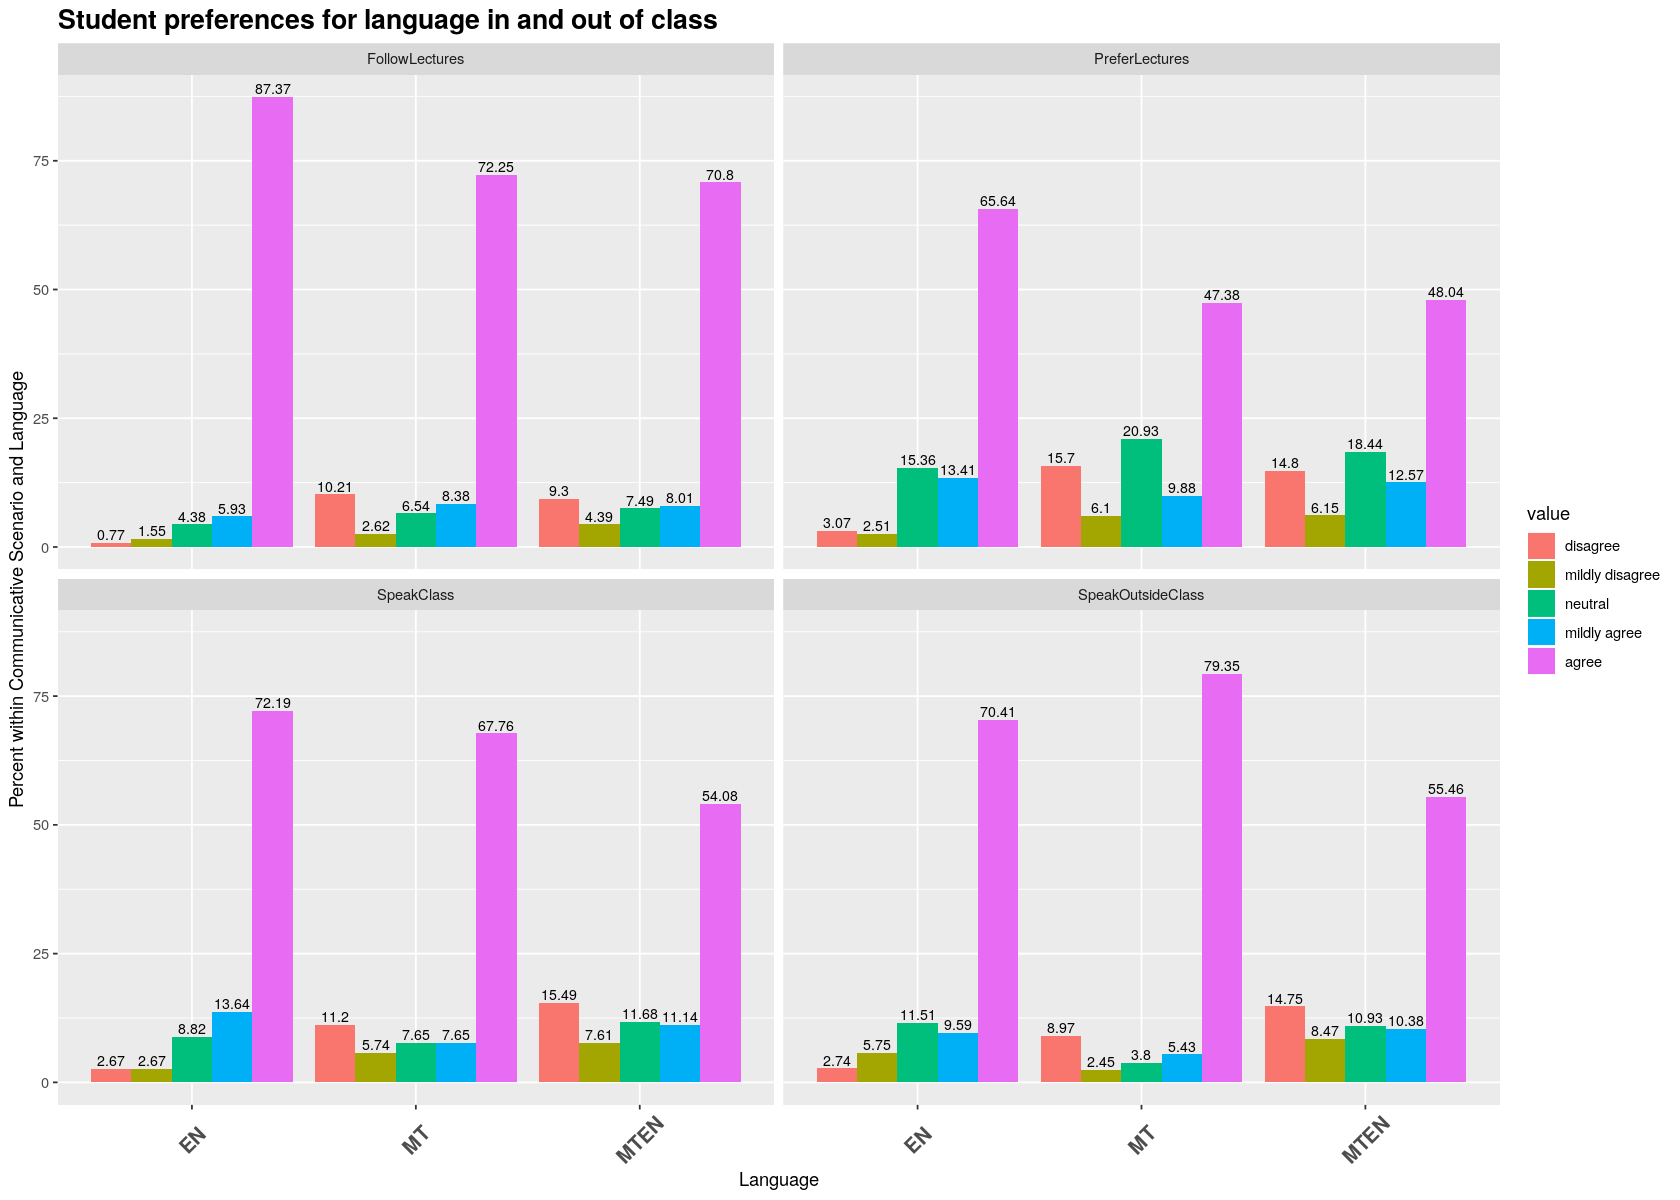

In [135]:
ggplot(subset(stlectures, !is.na(value)), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_wrap(~Context, ncol=2) +
    ggtitle("Student preferences for language in and out of class") +
    labs(y="Percent within Communicative Scenario and Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

* In lectures, most students find it easy to follow in English, and there is some evidence of a preference for English as language of instruction. However, there are significant numbers who strongly agreed with the statements *I would prefer to follow lectures/seminars in Maltese/Maltese and English*, and for this question, the overall preference for English is lower.
* For the questions related to speaking in and out of class, there is no clear preference for either language, though there is a higher number who strongly agree with the statement *I feel comfortable using English in the classroom*.

# 6. The Language of assessment

Both students and academics were asked for their preference for EN, Mt or both in examination settings. Academics and students were asked to rate their agreement with the statement: *Exams for all subjects should be in X*, while students were further asked which language they prefer.

In [139]:
exams <- subset(acad_mlt, Context=="Exams")
exams$Role <- 'Academic'
exams_st <- subset(stud_mlt, Context=='Exams' | Context=='ExamsPref')
exams_st$Role <- 'Student'
exams <- rbind(exams, exams_st)
exams$Context <- as.character(exams$Context)

#Turn value into a factor and order levels properly
exams$value <- factor(exams$value, levels=c("disagree", "mildly disagree", "neutral", 
                                                    "mildly agree", "agree"))

In [145]:
exams_sm <- data.frame(prop.table(ftable(table(exams$Role,
                                                 exams$Context, 
                                                 exams$Lang, 
                                                 exams$value), margins=2), 1) * 100)
names(exams_sm) <- c("Role", "Context", "Lang", "value", "Prop")

Below we show the extent to which students and academics agree that exams for all subjects should be in EN, MT or both.

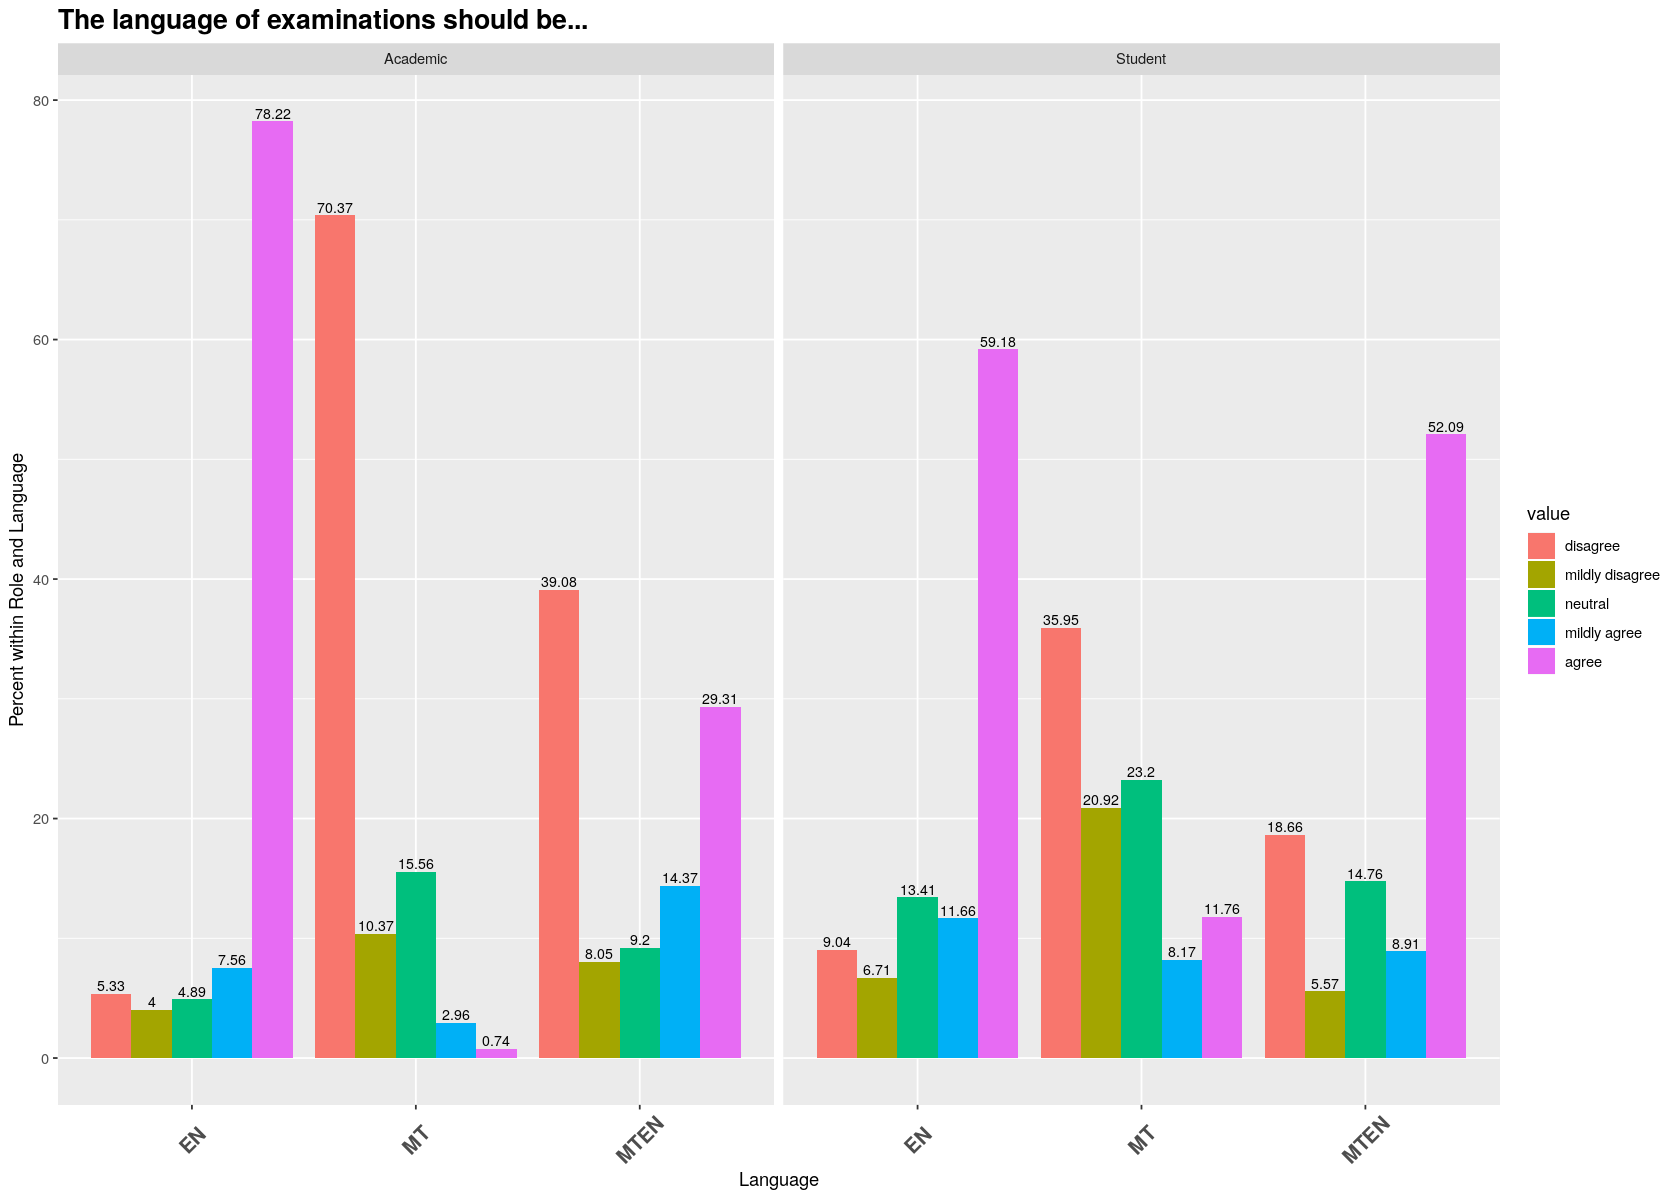

In [146]:
ggplot(subset(exams_sm, !is.na(value) & Context != 'ExamsPref'), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_wrap(~Role, ncol=2) +
    ggtitle("The language of examinations should be...") +
    labs(y="Percent within Role and Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

Observations:
* Both students and academis show a tendency for preferring exams to be in English. This is more marked for academics.
* Among students, a sizeable proportion also agree that exams should be in both English and Maltese.

We next look at the *preference* expressed by students for language of examination.

Warning message:
“Removed 15 rows containing missing values (geom_bar).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


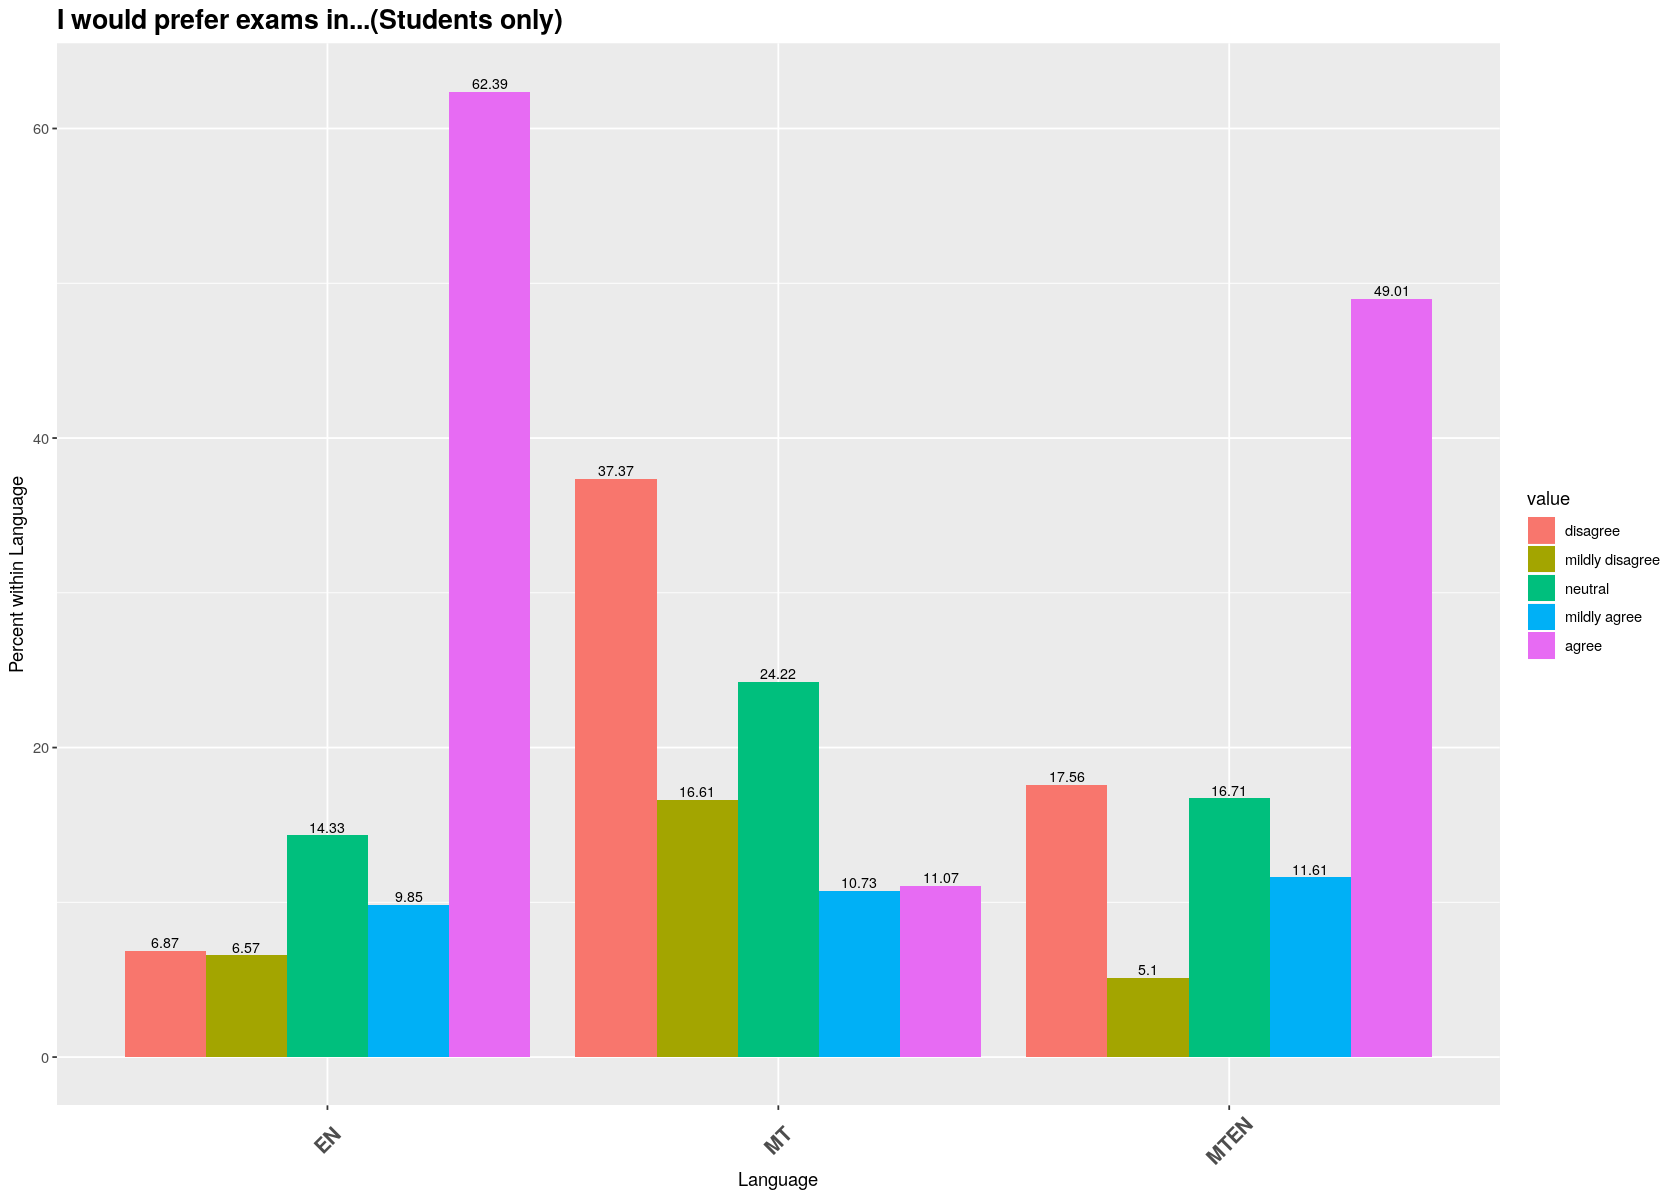

In [148]:
ggplot(subset(exams_sm, !is.na(value) & Context == 'ExamsPref'), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    ggtitle("I would prefer exams in...(Students only)") +
    labs(y="Percent within Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

The results above are consistent with those observed among students for the previous question: 
* a sizeable majority prefer English as the sole language of assessment
* However, a sizeable group also express strong agreement with the statement *I would prefer exams for all subjects to be  [in both English and Maltese]*.

# 7. Communicating with colleagues
ACadmic and non-academic staff were asked to report on their language preferences when speaking with colleages. Below, we quantify responses to the question *I speak to my colleagues only in...*.

In [160]:
nac_mlt <- melt_data(nonacademics, c("ID", "FICS", nonacad_questions$VariableName),
                       'Reports|StaffMeetings|SpeakColleagues|WriteMessages',
                     idvars=c("ID", "FICS"))

Warning message in if (is.na(idvars)) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“attributes are not identical across measure variables; they will be dropped”


In [167]:
spk_coll <- subset(nac_mlt, Context=="SpeakColleagues")[c("Lang", "Context", "value")]
spk_coll$Role <- 'Non-Academic'
ac_coll <- subset(acad_mlt, Context=="SpeakColleagues")[c("Lang", "Context", "value")]
ac_coll$Role <- "Academic"
spk_coll <- rbind(spk_coll, ac_coll)

In [170]:
spk_coll$Context <- as.character(spk_coll$Context)

# #Turn value into a factor and order levels properly
spk_coll$value <- factor(spk_coll$value, levels=c("always", "most of the time", "some of the time", 
                                                    "never"))

In [171]:
table(spk_coll$value)


          always most of the time some of the time            never 
             287              294              330              134 

In [172]:
spk <- data.frame(prop.table(ftable(table(spk_coll$Role, 
                                            spk_coll$Lang, 
                                            spk_coll$value), margins=2), 1) * 100)
names(spk) <- c("Role", "Lang", "value", "Prop")

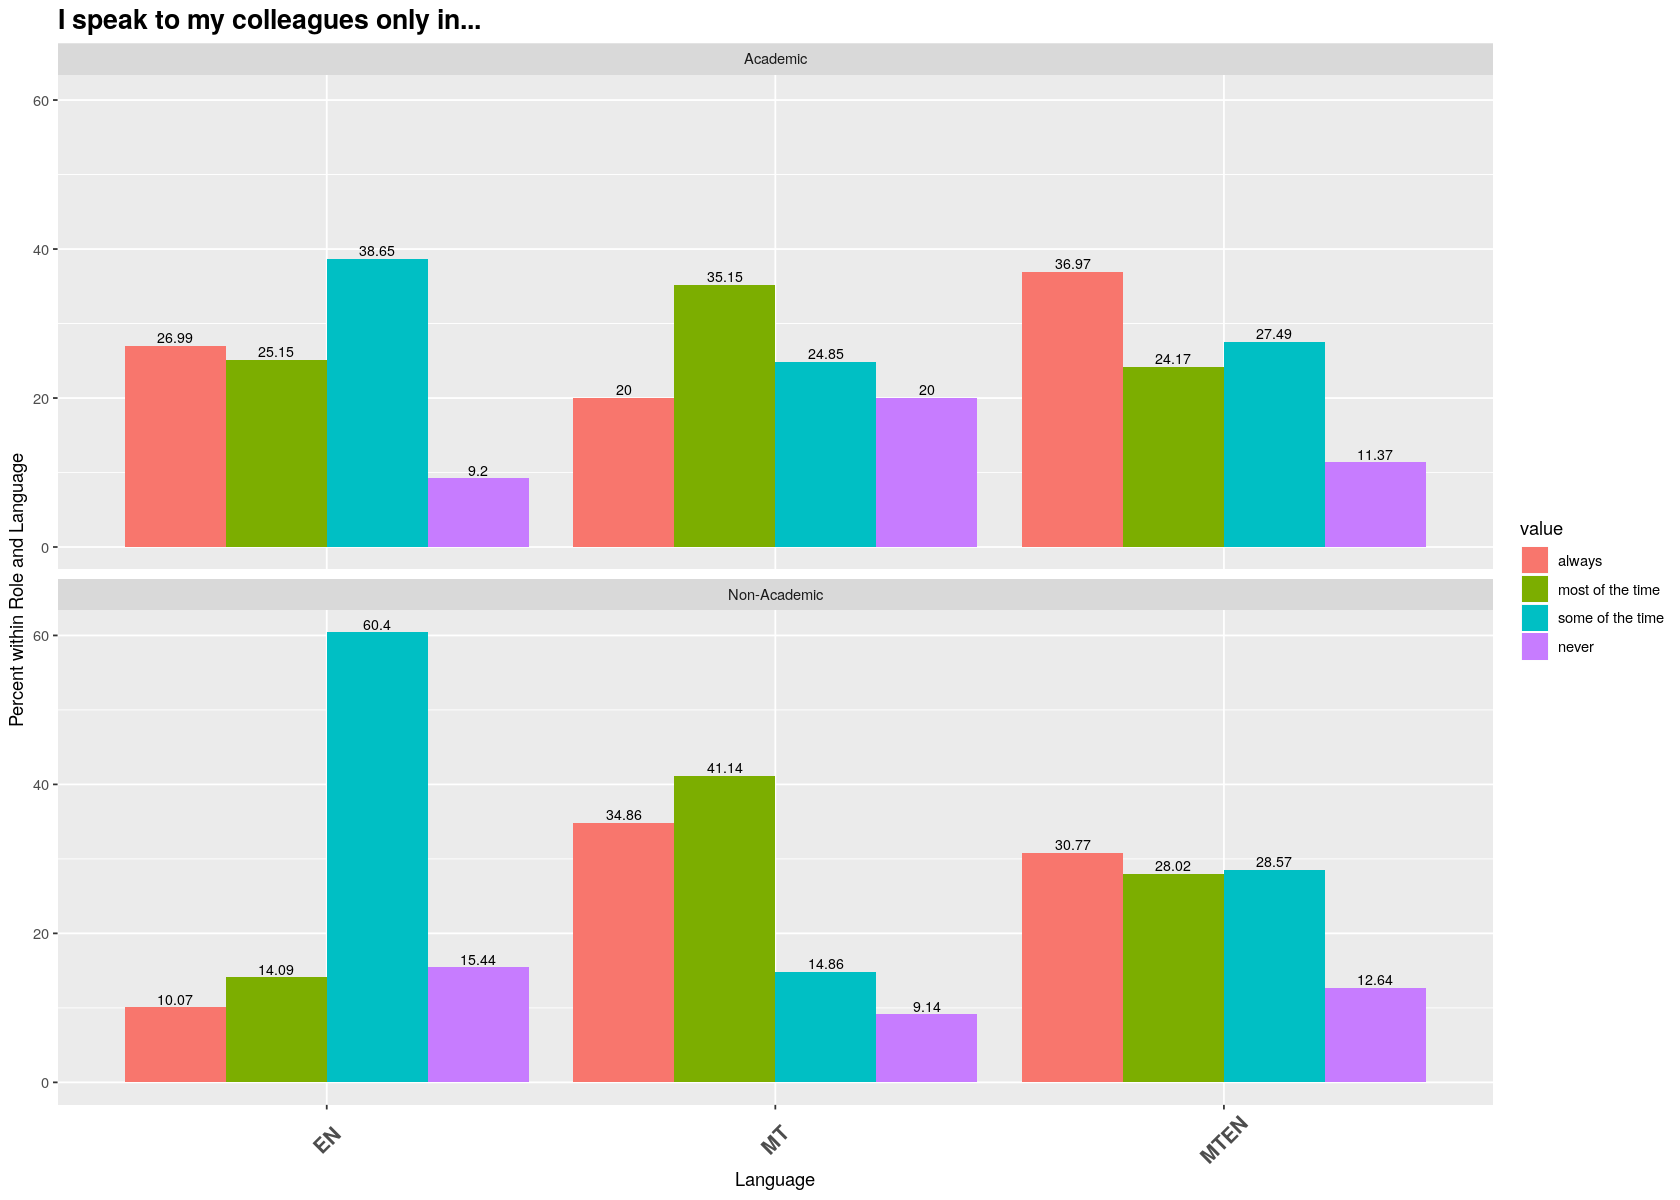

In [173]:
ggplot(subset(spk, !is.na(value)), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop, 2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_wrap(~Role, nrow=2) +
    ggtitle("I speak to my colleagues only in...") +
    labs(y="Percent within Role and Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

* For both academic and non-academic staff, a self-reported majority use English at least some of the time.
* For both groups, there is a marked tendency to use both languages.
* More academics use English only, while significantly more non-academics use Maltese only.


# 8. Questions specific to non-academic staff
In this section, we consider questions asked only to academic staff, concerning report writing, staff meetings and writing messages. (Some of these overlap with questions asked to non-academics, but since the occupational roles are quite different, it seems sensible to analyse them separately).

In [183]:
nac_comms <- subset(nac_mlt, Context=="Reports" | Context=="StaffMeetings" | Context=="WriteMessages")

nac_comms$Context <- as.character(nac_comms$Context)

#Factorise
nac_comms$value <- factor(nac_comms$value, levels=c("disagree", "mildly disagree", "neutral", "mildly agree", "agree"))

In [184]:
nac_comms_sm <- data.frame(prop.table(ftable(table(nac_comms$Context, 
                                            nac_comms$Lang, 
                                            nac_comms$value), margins=2), 1) * 100)
names(nac_comms_sm) <- c("Context", "Lang", "value", "Prop")

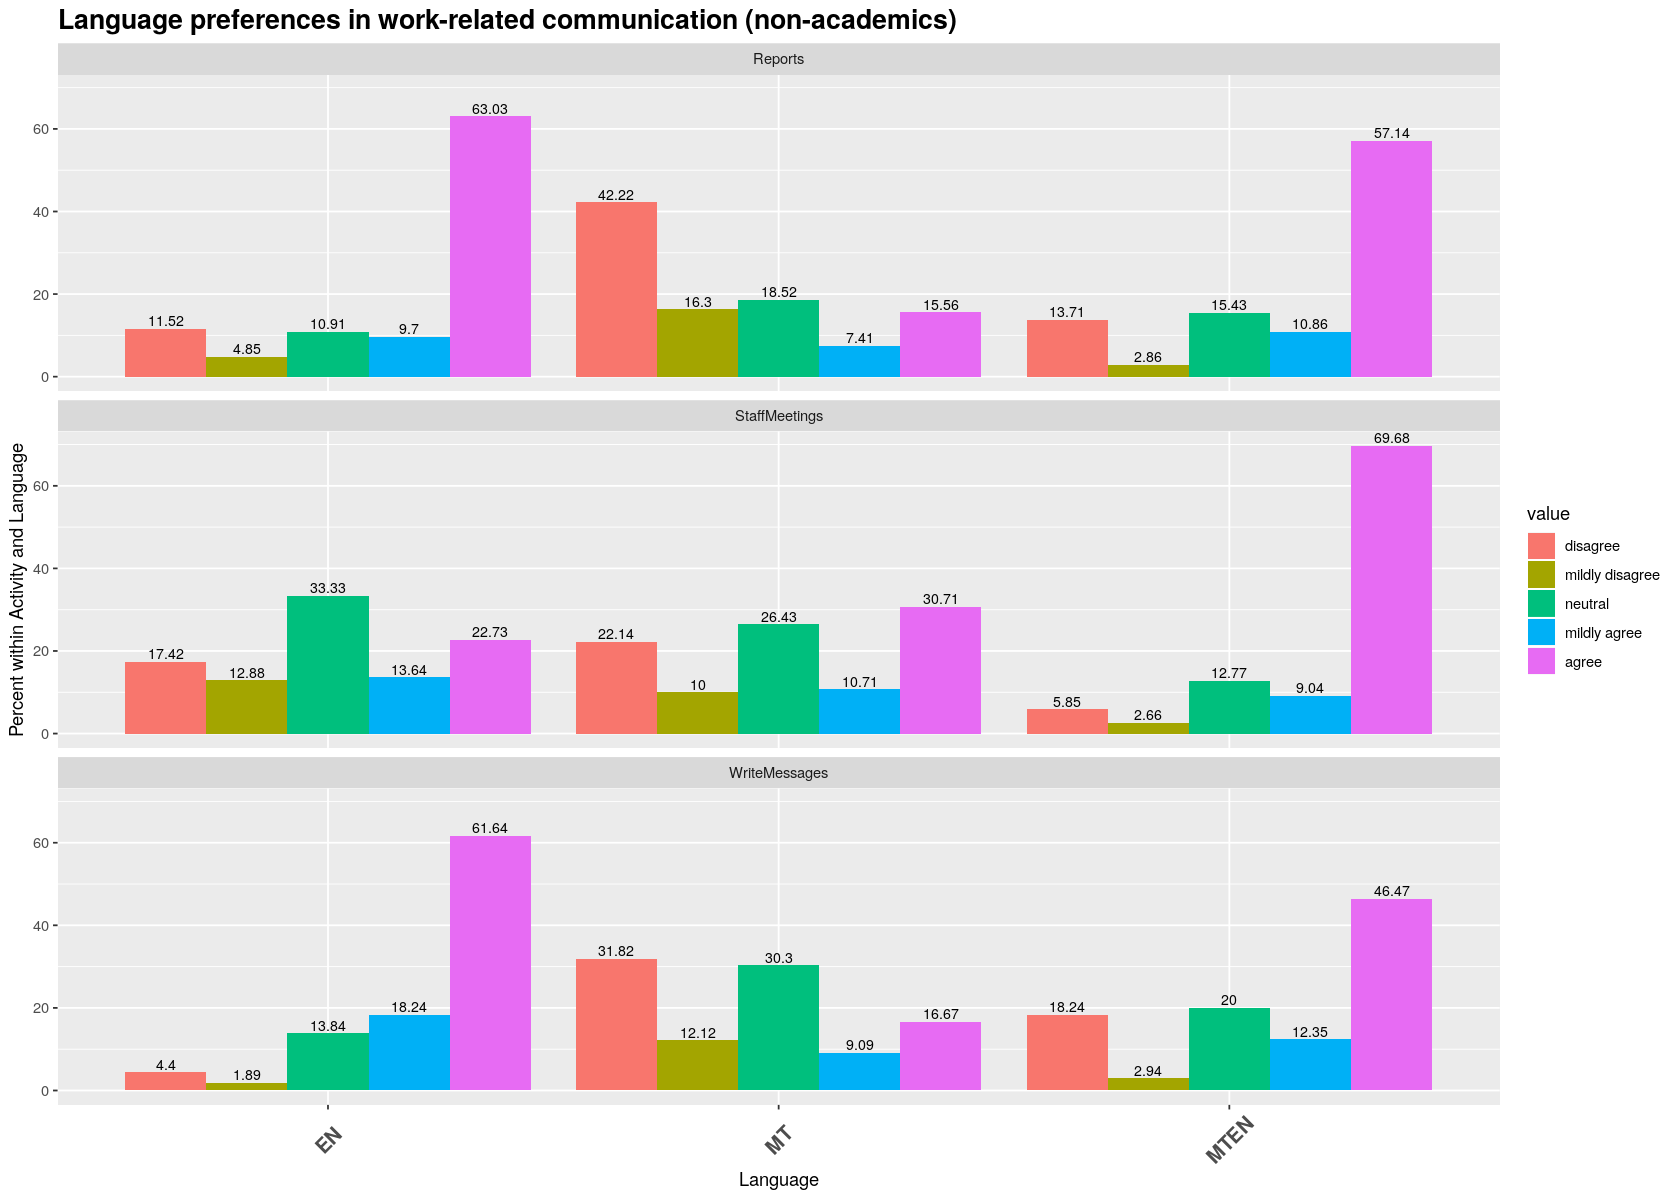

In [185]:
ggplot(subset(nac_comms_sm, !is.na(value)), aes(x=Lang, fill=value, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25, size=3)  +
    facet_wrap(~ Context, nrow=3) +
    ggtitle("Language preferences in work-related communication (non-academics)") +
    labs(y="Percent within Activity and Language", x="Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(axis.text.x = element_text(angle=45, vjust=.5, size=12, face='bold')) 

* Non-academic staff prefer to English only, or a mixture of Maltese and English in these contexts.
* For writing (reports or messages), the preference for English is much clearer, whereas for meetings, there is a stronger preference for a mixture of the two languages.